# Introduction

1. 這份 notebook 包含以下策略：
- S0: baseline: 只做單一時期進貨策略
- S1: Grid for F & R
- S2: Grid for R & Flexible F
- S12: Flexible R & Flexible F
- S14: R 與 F 的使用最佳化去找最佳解

2. 這份的 R 的範圍是設定是期初進貨。
假設 T= 1~10，
R 範圍則是 2~10。
當 R 為 5 代表在 T=4 結束或是等同於 T=5 開始前進貨


# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
import numpy as np
from datetime import datetime

#####################

salvage_value = 0
cost = 400
price = 1000
holding_cost = 0

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

CHUNK_SIZE = 60
data_size = CHUNK_SIZE * 3
train_size = 0.5
testing_size = 0.5

T = 10
service_level = 0.95  # 服務水準
M = 5000000
LASSO_BETA = 100
LASSO_ALPHA = 0.1
LASSO_BETA_SECOND_TRAIN = 0.9

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1
np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 20000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [6]:
# show_models("linear_constraint_med_with_holding_cost")

In [7]:
# show_models("med_with_holding_cost")

## Visualization 

In [8]:
def plot_strategies_profits_scatter(save_type, dfs: dict):
    names = list(dfs.keys())
    df_list = [dfs[name] for name in names]

    if len(df_list) <= 1:
        print("No dataframes to plot.")
        return

    pairs = list(itertools.combinations(range(len(df_list)), 2))
    num_pairs = len(pairs)
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)
        df_i, df_j = df_list[i], df_list[j]

        if df_i is None or df_j is None or df_i.empty or df_j.empty:
            continue
        if len(df_i) != len(df_j):
            continue

        ax = axes[row, col]
        ax.scatter(df_i["profits"], df_j["profits"], alpha=0.6)
        ax.plot(
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            "k--",
            linewidth=1,
        )
        ax.set_xlabel(names[i])
        ax.set_ylabel(names[j])
        ax.set_title(f"{names[i]} vs {names[j]}")

    # Remove empty subplots
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/plot_strategies_profits_scatter_{save_type}.png"
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    plt.show()
    plt.close()

In [9]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [10]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the fixed range of the y-axis
    max_value = max(
        max(test_ratios.values(), default=0), max(train_ratios.values(), default=0)
    )
    y_max = min(max_value + 0.1, 1.0)  # Limit max y to 1.0
    y_min = -y_max  # Keep symmetric scaling

    # Ensure y-axis tick marks are at intervals of 0.05
    y_ticks = np.arange(y_min, y_max + 0.05, 0.05)  # Generate ticks

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())

    # Set fixed y-axis range and ticks
    plt.ylim(y_min, y_max)
    plt.yticks(y_ticks)  # Apply fixed 0.05 intervals

    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [11]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [12]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [13]:
# 線性模型預測公式
def compute_f_F_Q(X_data, alphas, Q_star):
    f = sum(X_data[j] * alphas[j] for j in range(len(alphas)))
    big_f = 1 / (1 + np.exp(-f))
    q0 = big_f * Q_star
    print(f"f_vars[i]: {f:.4f}, F_vars[i]: {big_f:.4f}, Q0_vars[i]: {q0:.4f}")
    return f, big_f, q0

In [14]:
import math


def truncate_to_2(x):
    return math.floor(x * 100) / 100

In [15]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [16]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [17]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [18]:
calculate_service_level(salvage_value=salvage_value, cost=cost, price=price)

0.6

In [19]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    gamma_values=None
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
        "gamma_values": [gamma_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        # "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [20]:
np.random.seed(0)

# full_df = pd.DataFrame(
#     {
#         "X1": np.zeros(data_size),
#         "X2": np.zeros(data_size),
#         "X3": np.zeros(data_size),
#         "X4": np.random.uniform(5, 15, data_size),
#     }
# )

full_df = pd.DataFrame(
    {
        "X1": np.zeros(data_size),
        "X2": np.zeros(data_size),
        "X3": np.zeros(data_size),  # 將作為轉折時間
        # "X4": np.random.uniform(5, 15, data_size),
    }
)

for i in range(0, data_size, CHUNK_SIZE):
    half_chunk = CHUNK_SIZE // 2
    # 訓練 (前 half_chunk)
    full_df.loc[i : i + half_chunk - 1, "X1"] = np.random.uniform(
        15, 20, size=half_chunk
    )
    full_df.loc[i : i + half_chunk - 1, "X2"] = 0
    full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(
        250, 300, size=half_chunk
    )

    # 測試 (後 half_chunk)
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = np.random.uniform(
        15, 20, size=half_chunk
    )
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
        60, 70, size=half_chunk
    )


# # 初始化 X3
# X3_values = np.zeros(data_size)

# # 對每個 chunk 設定對應的 X3 範圍
# for i in range(0, data_size, CHUNK_SIZE):
#     half_chunk = CHUNK_SIZE // 2
#     # 訓練資料 X3：200~250
#     X3_values[i : i + half_chunk] = np.random.uniform(
#         250, 300, size=min(half_chunk, data_size - i)
#     )
#     # 測試資料 X3：40~90
#     X3_values[i + half_chunk : i + CHUNK_SIZE] = np.random.uniform(
#         50, 100, size=min(half_chunk, data_size - i - half_chunk)
#     )

# # 填入 full_df
# full_df["X3"] = X3_values
full_df

,X1,X2,X3
0,17.744068,0.0,263.227781
1,18.575947,0.0,288.711684
2,18.013817,0.0,272.807517
3,17.724416,0.0,278.421697
4,17.118274,0.0,250.939490
...,...,...,...
175,17.280703,1.0,66.813925
176,18.416407,1.0,62.775961
177,18.478127,1.0,61.288606
178,16.417594,1.0,63.926757


In [21]:
# np.random.seed(0)

# # 初始化 full_df，包含 X1, X2, X3, X4
# # 其他變數 (例如 X4) 用 uniform 隨機數
# full_df = pd.DataFrame(
#     {
#         "X1": np.zeros(data_size),
#         "X2": np.zeros(data_size),
#         "X3": np.zeros(data_size),  # 將作為轉折時間
#         # "X4": np.random.uniform(5, 15, data_size),
#     }
# )

# # # 根據 chunk，對第一半 (訓練) 設定 X1=1，對第二半 (測試) 設定 X2=1，
# # # 並設定 X3 為轉折時間:
# # #  訓練：X3 ~ Uniform(7, 9)
# # #  測試：X3 ~ Uniform(2, 4)
# # for i in range(0, data_size, CHUNK_SIZE):
# #     half_chunk = CHUNK_SIZE // 2
# #     # 訓練 (前 half_chunk)
# #     full_df.loc[i : i + half_chunk - 1, "X1"] = 1
# #     full_df.loc[i : i + half_chunk - 1, "X2"] = 0
# #     full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(7, 9, size=half_chunk)

# #     # 測試 (後 half_chunk)
# #     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = 0
# #     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
# #     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
# #         2, 4, size=half_chunk
# #     )

# for i in range(0, data_size, CHUNK_SIZE):
#     half_chunk = CHUNK_SIZE // 2
#     # 訓練部分（前 half_chunk）
#     full_df.loc[i : i + half_chunk - 1, "X1"] = 250
#     full_df.loc[i : i + half_chunk - 1, "X2"] = 0
#     full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(6, 8, size=half_chunk)

#     # 測試部分（後 half_chunk）
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = 100
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
#         2, 4, size=half_chunk
#     )

# # 顯示 full_df（部分）
# full_df.head(30)

In [22]:
features_num = full_df.shape[1]
features_num

3

### Split training and testing data


In [23]:
# from sklearn.preprocessing import StandardScaler


# def train_data_split_and_normalized(data, train_size=0.5):
#     folds = []
#     scalers = []

#     # 計算訓練集的大小
#     train_len = int(len(data) * train_size)

#     # 將資料切分為前半部分為訓練集，後半部分為測試集
#     train_data = data.iloc[:train_len].reset_index(drop=True)
#     test_data = data.iloc[train_len:].reset_index(drop=True)

#     # # 標準化處理
#     # scaler = StandardScaler()
#     # train_data_normalized = scaler.fit_transform(train_data)
#     # test_data_normalized = scaler.transform(test_data)

#     # # 將標準化資料轉回 DataFrame
#     # train_data_normalized = pd.DataFrame(train_data_normalized, columns=data.columns)
#     # test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

#     # # 將資料加入 folds 與 scaler
#     # folds.append((train_data_normalized, test_data_normalized))
#     # scalers.append(scaler)

#     # 將資料加入 folds 與 scaler
#     folds.append((train_data, test_data))
#     scalers.append(None)

#     return folds, scalers


# training_data_folds, scalers = train_data_split_and_normalized(full_df, train_size)

# for i, (train, test) in enumerate(training_data_folds):
#     print(f"Fold {i + 1}:")
#     print(f"Train size: {train.shape}, Test size: {test.shape}")
#     print("Train (normalized):")
#     print(train.head())
#     print("Test (normalized):")
#     print(test.head())
#     print()

In [24]:
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalized_k_fold(data, train_size=0.5, chunk_size=CHUNK_SIZE):

    folds = []
    scalers = []
    train_chunk = int(train_size * chunk_size)
    n = len(data)

    # 依序將資料切分成 chunk_size 大小的子集
    for start in range(0, n, chunk_size):
        if start + chunk_size > n:
            break  # 若剩餘資料不足一個完整的 chunk，則跳過
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)

        # # 建立並使用 StandardScaler 分別標準化當前的訓練與測試資料
        # scaler = StandardScaler()
        # train_data_normalized = scaler.fit_transform(train_data)
        # test_data_normalized = scaler.transform(test_data)

        # # 轉回 DataFrame 格式
        # train_data_normalized = pd.DataFrame(
        #     train_data_normalized, columns=data.columns
        # )
        # test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # folds.append((train_data_normalized, test_data_normalized))
        # scalers.append(scaler)

        folds.append((train_data, test_data))
        scalers.append(None)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized_k_fold(full_df)

for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.shape)
    print(train.head())
    print("Test (normalized):")
    print(test.shape)
    print(test.head())
    print()

Fold 1:
Train size: (30, 3), Test size: (30, 3)
Train (normalized):
(30, 3)
          X1   X2          X3
0  17.744068  0.0  263.227781
1  18.575947  0.0  288.711684
2  18.013817  0.0  272.807517
3  17.724416  0.0  278.421697
4  17.118274  0.0  250.939490
Test (normalized):
(30, 3)
          X1   X2         X3
0  15.794848  1.0  63.185690
1  15.551876  1.0  66.674104
2  18.281648  1.0  61.317979
3  15.690915  1.0  67.163272
4  15.982912  1.0  62.894061

Fold 2:
Train size: (30, 3), Test size: (30, 3)
Train (normalized):
(30, 3)
          X1   X2          X3
0  18.626271  0.0  257.472415
1  17.506622  0.0  293.406303
2  19.780418  0.0  258.124647
3  18.219951  0.0  280.777978
4  17.119275  0.0  256.190999
Test (normalized):
(30, 3)
          X1   X2         X3
0  15.823471  1.0  69.903389
1  18.107392  1.0  62.168970
2  17.886143  1.0  66.630782
3  16.189464  1.0  62.633224
4  19.671070  1.0  60.206510

Fold 3:
Train size: (30, 3), Test size: (30, 3)
Train (normalized):
(30, 3)
        

## Data2: demand_df


### mu of each time(t)


In [25]:
# 設定 b0, b1, b2
b0 = 0
b1 = 0
b2 = 0
b3 = 1
# b4 = 0
bt = 0


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            # + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix


mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[:3]: \n{mu_matrix[:3]}")
print(
    f"mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]: \n{mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]}"
)


mu_df = pd.DataFrame(mu_matrix, columns=[f"t{t}" for t in range(1, T + 1)])
mu_df.head(30)

mu_matrix shape: (180, 10)
mu_matrix[:3]: 
[[263.22778061 263.22778061 263.22778061 263.22778061 263.22778061
  263.22778061 263.22778061 263.22778061 263.22778061 263.22778061]
 [288.71168447 288.71168447 288.71168447 288.71168447 288.71168447
  288.71168447 288.71168447 288.71168447 288.71168447 288.71168447]
 [272.80751661 272.80751661 272.80751661 272.80751661 272.80751661
  272.80751661 272.80751661 272.80751661 272.80751661 272.80751661]]
mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]: 
[[257.47241523 257.47241523 257.47241523 257.47241523 257.47241523
  257.47241523 257.47241523 257.47241523 257.47241523 257.47241523]
 [293.40630287 293.40630287 293.40630287 293.40630287 293.40630287
  293.40630287 293.40630287 293.40630287 293.40630287 293.40630287]
 [258.12464673 258.12464673 258.12464673 258.12464673 258.12464673
  258.12464673 258.12464673 258.12464673 258.12464673 258.12464673]]


,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,263.227781,263.227781,263.227781,263.227781,263.227781,263.227781,263.227781,263.227781,263.227781,263.227781
1,288.711684,288.711684,288.711684,288.711684,288.711684,288.711684,288.711684,288.711684,288.711684,288.711684
2,272.807517,272.807517,272.807517,272.807517,272.807517,272.807517,272.807517,272.807517,272.807517,272.807517
3,278.421697,278.421697,278.421697,278.421697,278.421697,278.421697,278.421697,278.421697,278.421697,278.421697
4,250.939490,250.939490,250.939490,250.939490,250.939490,250.939490,250.939490,250.939490,250.939490,250.939490
5,280.881775,280.881775,280.881775,280.881775,280.881775,280.881775,280.881775,280.881775,280.881775,280.881775
6,280.604786,280.604786,280.604786,280.604786,280.604786,280.604786,280.604786,280.604786,280.604786,280.604786
7,280.846700,280.846700,280.846700,280.846700,280.846700,280.846700,280.846700,280.846700,280.846700,280.846700
8,297.187404,297.187404,297.187404,297.187404,297.187404,297.187404,297.187404,297.187404,297.187404,297.187404
9,284.091015,284.091015,284.091015,284.091015,284.091015,284.091015,284.091015,284.091015,284.091015,284.091015


In [26]:
# def cal_mu_matrix_with_turning_point(
#     data_size, T, training_df, sigma_t, delta=50, gamma=1.0
# ):
#     np.random.seed(0)
#     mu_matrix = np.zeros((data_size, T))
#     random_noises = np.random.normal(0, sigma_t, T)

#     # 用 X1, X2 區分高低 baseline，X3 作為轉折點
#     for i in range(data_size):
#         # 根據 X1 / X2 決定 baseline range
#         if training_df.loc[i, "X2"] == 1:

#             # 低 baseline
#             # baseline1 = np.random.uniform(50, 100)
#             # baseline2 = np.random.uniform(100, 150)
#             baseline1 = np.random.uniform(100, 120)
#             baseline2 = np.random.uniform(160, 180)

#         else:
#             # 高 baseline
#             baseline1 = np.random.uniform(120, 140)
#             baseline2 = np.random.uniform(160, 180)

#         # 將 X3 視為轉折點
#         t_switch = training_df.loc[i, "X3"]

#         # 對於每一個時間點，生成一個平滑轉折項
#         for t in range(1, T + 1):
#             # 基本線性部分：當 t < t_switch 則為 baseline1，之後用 baseline2
#             if t < t_switch:
#                 mu_base = baseline1
#             else:
#                 mu_base = baseline2
#             # 加上轉折項（使轉折更平滑或更明顯）
#             turning_term = delta / (1 + np.exp(-gamma * (t - t_switch)))
#             mu_matrix[i, t - 1] = mu_base + turning_term
#     return mu_matrix


# mu_matrix = cal_mu_matrix_with_turning_point(
#     data_size, T, full_df, 1, delta=50, gamma=1.0
# )
# mu_df = pd.DataFrame(mu_matrix, columns=[f"t{t}" for t in range(1, T + 1)])
# mu_df.head(30)

In [27]:
# 每一筆 row 的總和
row_sums = mu_df.sum(axis=1)

# 前 25 筆 row 的總和平均
first_25_avg = row_sums.head(25).mean()

# 後 25 筆（第 6 到第 30 筆）的 row 總和平均
last_25_avg = row_sums.iloc[5:30].mean()

print("前 25 筆資料的 row 總和平均：", first_25_avg)
print("後 25 筆資料的 row 總和平均：", last_25_avg)

前 25 筆資料的 row 總和平均： 2735.4547950744563
後 25 筆資料的 row 總和平均： 2729.3804436282107


Train indices: [0, 1, 2]
Test indices: [30, 31, 32]


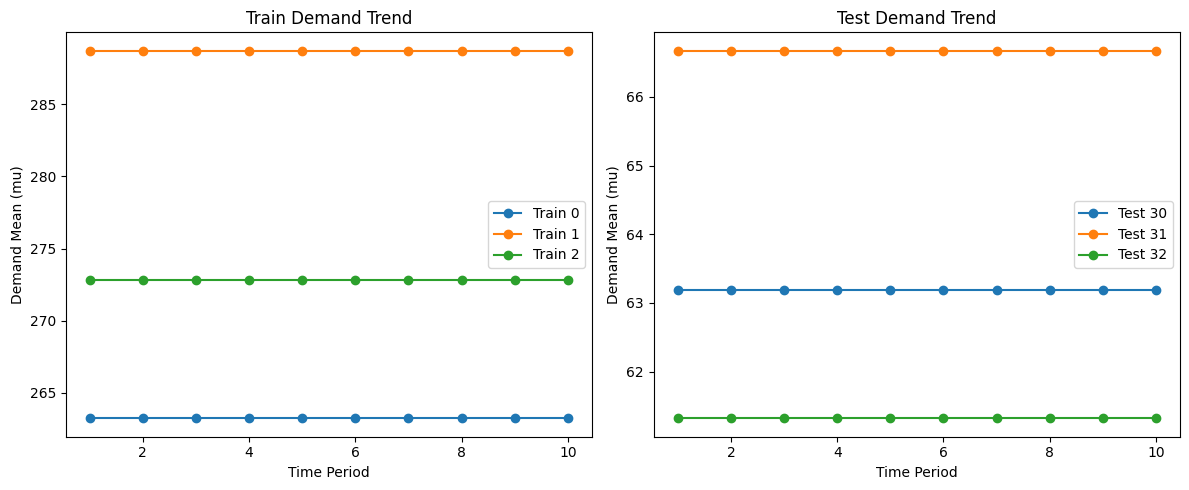

In [28]:
# 現在我們從 full_df 中取出第一個 chunk（共 CHUNK_SIZE 筆），並分別選出前 3 筆訓練與後 3 筆測試觀測
chunk_indices = range(0, CHUNK_SIZE)
train_indices = [i for i in chunk_indices if full_df.loc[i, "X2"] == 0][:3]
test_indices = [i for i in chunk_indices if full_df.loc[i, "X2"] == 1][:3]

print("Train indices:", train_indices)
print("Test indices:", test_indices)

# 繪圖：X軸為 t=1..T, Y軸為 mu
plt.figure(figsize=(12, 5))

# 畫出訓練資料趨勢
plt.subplot(1, 2, 1)
for i in train_indices:
    plt.plot(range(1, T + 1), mu_matrix[i, :], marker="o", label=f"Train {i}")
plt.title("Train Demand Trend")
plt.xlabel("Time Period")
plt.ylabel("Demand Mean (mu)")
plt.legend()

# 畫出測試資料趨勢
plt.subplot(1, 2, 2)
for i in test_indices:
    plt.plot(range(1, T + 1), mu_matrix[i, :], marker="o", label=f"Test {i}")
plt.title("Test Demand Trend")
plt.xlabel("Time Period")
plt.ylabel("Demand Mean (mu)")
plt.legend()

plt.tight_layout()
plt.show()

### sigma matrix


In [29]:
X = full_df.values
feature_num = X.shape[1]
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

X.shape: (180, 3)
coefficients.shape: (3, 10)
coefficients: [[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]]


In [30]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 300

# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
# sigma_matrix = 0 + sigma_matrix * 10
sigma_matrix = 0 + sigma_matrix * 3
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 2
# sigma_matrix = 10 + sigma_matrix * 5
# sigma_matrix = 0 + sigma_matrix * 1


# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

Value range: (np.float64(6.52532256287166e-101), np.float64(1.0))
New Value range: (np.float64(1.957596768861498e-100), np.float64(3.0))


((180, 10),
 array([[3.00000000e+00, 3.10495103e-07, 3.00000000e+00, ...,
         3.00000000e+00, 2.55633183e-21, 2.40095250e-49],
        [3.00000000e+00, 5.17192065e-08, 3.00000000e+00, ...,
         3.00000000e+00, 2.71916412e-23, 2.39663759e-54],
        [3.00000000e+00, 1.56894532e-07, 3.00000000e+00, ...,
         3.00000000e+00, 4.67974265e-22, 3.08771348e-51],
        ...,
        [3.00000000e+00, 1.32152427e+00, 3.00000000e+00, ...,
         3.00000000e+00, 4.19919543e-06, 1.90352288e-07],
        [3.00000000e+00, 8.88361049e-01, 3.00000000e+00, ...,
         2.99999999e+00, 4.32740778e-06, 1.65168766e-08],
        [3.00000000e+00, 6.93852627e-01, 3.00000000e+00, ...,
         2.99999999e+00, 1.47763857e-06, 1.53893061e-09]]))

### corr matrix


In [31]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [32]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (180, 10, 10)
cov_matrices: 
[[ 9.00000000e+000  3.29971956e-007  5.00205241e+000  3.22391022e-088
  -3.48996324e+000 -7.87501086e-083 -8.91655219e-001 -2.48349295e+000
  -3.74930496e-021 -1.50717596e-050]
 [ 3.29971956e-007  9.64072090e-014  6.01433369e-007  1.95545168e-095
  -4.97378026e-007 -5.99180608e-090 -3.41483355e-007  6.72813219e-008
   8.72769314e-029 -3.66228926e-057]
 [ 5.00205241e+000  6.01433369e-007  9.00000000e+000  1.42547596e-088
  -3.85642497e+000 -1.15342564e-082 -4.96388886e+000  9.50629143e-002
  -3.17685146e-021 -9.27070564e-050]
 [ 3.22391022e-088  1.95545168e-095  1.42547596e-088  3.34687694e-176
  -2.38037909e-088 -2.34820140e-171  9.12341690e-089 -3.46326180e-088
   4.16874747e-110  1.07252633e-137]
 [-3.48996324e+000 -4.97378026e-007 -3.85642497e+000 -2.38037909e-088
   9.00000000e+000  1.81118041e-082  2.70279307e+000  2.64617719e+000
  -1.17887252e-021 -7.81859877e-050]
 [-7.87501086e-083 -5.99180608e-090 -1.15342564e-082 -2.34820140e-

In [33]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [34]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,260.665332,263.227780,256.612851,263.227781,270.395186,263.227781,262.959187,261.587350,263.227781,263.227781
1,288.757548,288.711684,285.892907,288.711684,287.950668,288.711684,289.755310,284.542984,288.711684,288.711684
2,278.704773,272.807517,275.426989,272.807517,264.746244,272.807517,266.943818,269.012408,272.807517,272.807517
3,278.580754,278.421697,277.869368,278.421697,275.329949,278.421697,282.195725,280.365448,278.421697,278.421697
4,255.511307,250.939491,257.341987,250.939490,254.054255,250.939490,248.382853,253.383650,250.939490,250.939490
...,...,...,...,...,...,...,...,...,...,...
175,66.168444,66.454947,63.176182,66.813925,62.964852,66.813925,68.137735,63.880811,66.813927,66.813925
176,64.485860,61.910370,62.582051,62.775961,62.879077,62.775961,66.812742,66.114778,62.775959,62.775961
177,60.733121,60.416872,62.428642,61.288606,64.006363,61.288606,59.866799,63.485712,61.288605,61.288606
178,67.642460,63.574845,63.404274,63.926757,63.508075,63.926757,69.842216,61.366742,63.926748,63.926757


### Replace negative values to 0


In [35]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,260.665332,263.227780,256.612851,263.227781,270.395186,263.227781,262.959187,261.587350,263.227781,263.227781
1,288.757548,288.711684,285.892907,288.711684,287.950668,288.711684,289.755310,284.542984,288.711684,288.711684
2,278.704773,272.807517,275.426989,272.807517,264.746244,272.807517,266.943818,269.012408,272.807517,272.807517
3,278.580754,278.421697,277.869368,278.421697,275.329949,278.421697,282.195725,280.365448,278.421697,278.421697
4,255.511307,250.939491,257.341987,250.939490,254.054255,250.939490,248.382853,253.383650,250.939490,250.939490
...,...,...,...,...,...,...,...,...,...,...
175,66.168444,66.454947,63.176182,66.813925,62.964852,66.813925,68.137735,63.880811,66.813927,66.813925
176,64.485860,61.910370,62.582051,62.775961,62.879077,62.775961,66.812742,66.114778,62.775959,62.775961
177,60.733121,60.416872,62.428642,61.288606,64.006363,61.288606,59.866799,63.485712,61.288605,61.288606
178,67.642460,63.574845,63.404274,63.926757,63.508075,63.926757,69.842216,61.366742,63.926748,63.926757


### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [36]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,2632.277806,2628.358808,5.934835,3.208153,84.992290
1,2887.116845,2880.457840,5.934835,1.501990,295.131475
2,2728.075166,2718.871815,5.934835,3.833263,54.824635
3,2784.216974,2786.449732,5.934835,1.655663,258.456666
4,2509.394900,2523.371503,5.934835,2.541082,133.555391
...,...,...,...,...,...
175,668.139251,658.038674,6.070294,1.695509,258.021880
176,627.759610,635.888720,6.164034,1.567045,293.354050
177,612.886057,616.091931,6.191054,1.248015,396.072070
178,639.267568,645.045630,6.076675,2.293171,164.990072


### Validate normal distribution


In [37]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,260.665332,263.227780,256.612851,263.227781,270.395186,263.227781,262.959187,261.587350,263.227781,263.227781
1,288.757548,288.711684,285.892907,288.711684,287.950668,288.711684,289.755310,284.542984,288.711684,288.711684
2,278.704773,272.807517,275.426989,272.807517,264.746244,272.807517,266.943818,269.012408,272.807517,272.807517
3,278.580754,278.421697,277.869368,278.421697,275.329949,278.421697,282.195725,280.365448,278.421697,278.421697
4,255.511307,250.939491,257.341987,250.939490,254.054255,250.939490,248.382853,253.383650,250.939490,250.939490
...,...,...,...,...,...,...,...,...,...,...
175,66.168444,66.454947,63.176182,66.813925,62.964852,66.813925,68.137735,63.880811,66.813927,66.813925
176,64.485860,61.910370,62.582051,62.775961,62.879077,62.775961,66.812742,66.114778,62.775959,62.775961
177,60.733121,60.416872,62.428642,61.288606,64.006363,61.288606,59.866799,63.485712,61.288605,61.288606
178,67.642460,63.574845,63.404274,63.926757,63.508075,63.926757,69.842216,61.366742,63.926748,63.926757


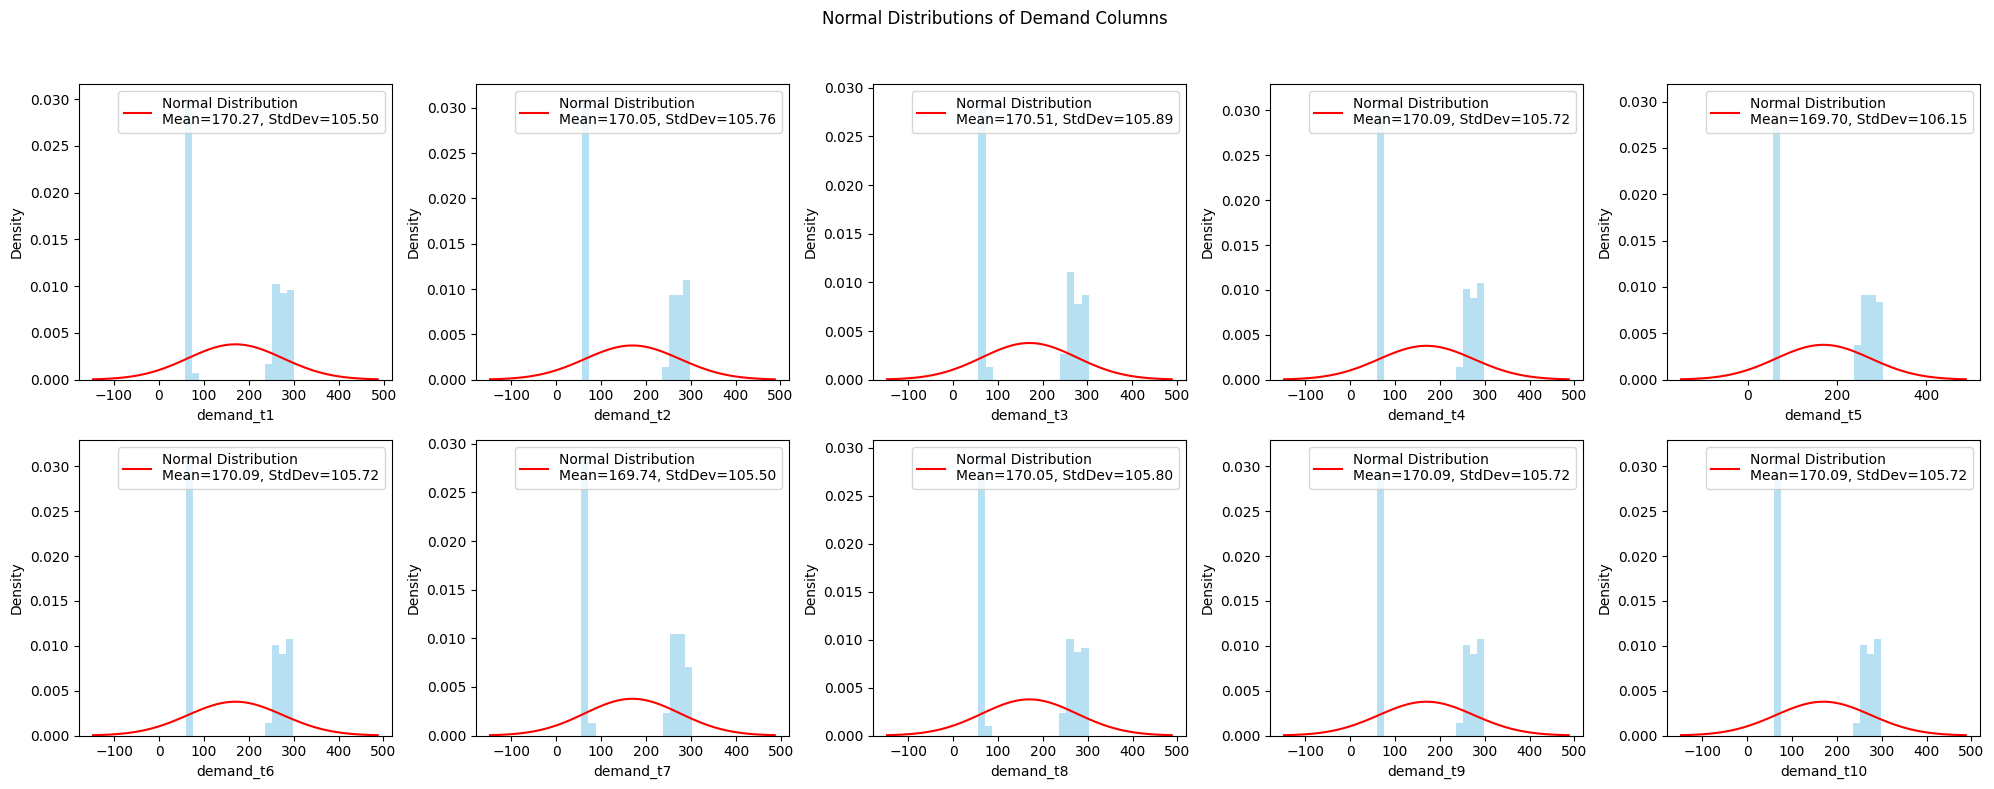

In [38]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [39]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,11193.050310,11215.968825,11229.862199,11211.999586,11249.588931,11211.999586,11182.764387,11213.959090,11211.999605,11211.999586
demand_t2,11215.968825,11246.809323,11257.752496,11242.649628,11282.937264,11242.649628,11213.721320,11247.752568,11242.649649,11242.649628
demand_t3,11229.862199,11257.752496,11275.607918,11253.278467,11290.720419,11253.278467,11219.518816,11258.378949,11253.278487,11253.278468
demand_t4,11211.999586,11242.649628,11253.278467,11238.933014,11279.899912,11238.933014,11210.390500,11243.785097,11238.933035,11238.933015
demand_t5,11249.588931,11282.937264,11290.720419,11279.899912,11330.466830,11279.899912,11254.235000,11287.162419,11279.899933,11279.899913
demand_t6,11211.999586,11242.649628,11253.278467,11238.933014,11279.899912,11238.933014,11210.390500,11243.785097,11238.933035,11238.933015
demand_t7,11182.764387,11213.721320,11219.518816,11210.390500,11254.235000,11210.390500,11191.500445,11216.069373,11210.390521,11210.390501
demand_t8,11213.959090,11247.752568,11258.378949,11243.785097,11287.162419,11243.785097,11216.069373,11256.899821,11243.785118,11243.785098
demand_t9,11211.999605,11242.649649,11253.278487,11238.933035,11279.899933,11238.933035,11210.390521,11243.785118,11238.933057,11238.933036
demand_t10,11211.999586,11242.649628,11253.278468,11238.933015,11279.899913,11238.933015,11210.390501,11243.785098,11238.933036,11238.933015


In [40]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,11184.050310,11215.468988,11224.860146,11211.999586,11253.078894,11211.999586,11183.656042,11216.442583,11211.999607,11211.999586
demand_t2,11215.468988,11246.343914,11256.841454,11242.649628,11283.690684,11242.649628,11214.238594,11247.650651,11242.649649,11242.649628
demand_t3,11224.860146,11256.841454,11266.607918,11253.278467,11294.576844,11253.278467,11224.482705,11258.283886,11253.278489,11253.278468
demand_t4,11211.999586,11242.649628,11253.278467,11238.933014,11279.899912,11238.933014,11210.390500,11243.785097,11238.933035,11238.933015
demand_t5,11253.078894,11283.690684,11294.576844,11279.899912,11321.466830,11279.899912,11251.532207,11284.516242,11279.899933,11279.899913
demand_t6,11211.999586,11242.649628,11253.278467,11238.933014,11279.899912,11238.933014,11210.390500,11243.785097,11238.933035,11238.933015
demand_t7,11183.656042,11214.238594,11224.482705,11210.390500,11251.532207,11210.390500,11182.500445,11215.718901,11210.390521,11210.390501
demand_t8,11216.442583,11247.650651,11258.283886,11243.785097,11284.516242,11243.785097,11215.718901,11247.899821,11243.785119,11243.785098
demand_t9,11211.999607,11242.649649,11253.278489,11238.933035,11279.899933,11238.933035,11210.390521,11243.785119,11238.933057,11238.933036
demand_t10,11211.999586,11242.649628,11253.278468,11238.933015,11279.899913,11238.933015,11210.390501,11243.785098,11238.933036,11238.933015


### Validate the corr matrix of damand_df is close to original setting


In [41]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,260.665332,263.227780,256.612851,263.227781,270.395186,263.227781,262.959187,261.587350,263.227781,263.227781
1,288.757548,288.711684,285.892907,288.711684,287.950668,288.711684,289.755310,284.542984,288.711684,288.711684
2,278.704773,272.807517,275.426989,272.807517,264.746244,272.807517,266.943818,269.012408,272.807517,272.807517
3,278.580754,278.421697,277.869368,278.421697,275.329949,278.421697,282.195725,280.365448,278.421697,278.421697
4,255.511307,250.939491,257.341987,250.939490,254.054255,250.939490,248.382853,253.383650,250.939490,250.939490
...,...,...,...,...,...,...,...,...,...,...
175,66.168444,66.454947,63.176182,66.813925,62.964852,66.813925,68.137735,63.880811,66.813927,66.813925
176,64.485860,61.910370,62.582051,62.775961,62.879077,62.775961,66.812742,66.114778,62.775959,62.775961
177,60.733121,60.416872,62.428642,61.288606,64.006363,61.288606,59.866799,63.485712,61.288605,61.288606
178,67.642460,63.574845,63.404274,63.926757,63.508075,63.926757,69.842216,61.366742,63.926748,63.926757


In [42]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.999650,0.999609,0.999646,0.998938,0.999646,0.999150,0.999023,0.999646,0.999646
demand_t2,0.999650,1.000000,0.999694,0.999980,0.999502,0.999980,0.999519,0.999636,0.999980,0.999980
demand_t3,0.999609,0.999694,1.000000,0.999647,0.998913,0.999647,0.998758,0.999301,0.999647,0.999647
demand_t4,0.999646,0.999980,0.999647,1.000000,0.999583,1.000000,0.999572,0.999633,1.000000,1.000000
demand_t5,0.998938,0.999502,0.998913,0.999583,1.000000,0.999583,0.999420,0.999428,0.999583,0.999583
demand_t6,0.999646,0.999980,0.999647,1.000000,0.999583,1.000000,0.999572,0.999633,1.000000,1.000000
demand_t7,0.999150,0.999519,0.998758,0.999572,0.999420,0.999572,1.000000,0.999280,0.999572,0.999572
demand_t8,0.999023,0.999636,0.999301,0.999633,0.999428,0.999633,0.999280,1.000000,0.999633,0.999633
demand_t9,0.999646,0.999980,0.999647,1.000000,0.999583,1.000000,0.999572,0.999633,1.000000,1.000000
demand_t10,0.999646,0.999980,0.999647,1.000000,0.999583,1.000000,0.999572,0.999633,1.000000,1.000000


In [43]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [44]:
def demand_data_split_data_k_fold(data):
    folds = []
    chunk_size = CHUNK_SIZE  # 每組 60 筆資料
    train_chunk = int(train_size * chunk_size)

    n = len(data)
    # 依序切分每一個 chunk
    for start in range(0, n, chunk_size):
        # 若剩餘資料不足 60 筆，這裡直接跳過
        if start + chunk_size > n:
            break
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)
        folds.append((train_data, test_data))

    return folds


# 使用函數切分資料
demand_folds = demand_data_split_data_k_fold(demand_df)

# 印出結果，每個 fold 的訓練與測試資料
for i, (train_data, test_data) in enumerate(demand_folds, 1):
    print(f"Fold {i}:")
    print("Train Data:")
    print(train_data.shape)
    print("Test Data:")
    print(test_data.shape)
    print("=" * 40)

Fold 1:
Train Data:
(30, 10)
Test Data:
(30, 10)
Fold 2:
Train Data:
(30, 10)
Test Data:
(30, 10)
Fold 3:
Train Data:
(30, 10)
Test Data:
(30, 10)


### Define the Q star(Q optimal)


In [45]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [46]:
demand_folds

[(     demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
  0   260.665332  263.227780  256.612851  263.227781  270.395186  263.227781   
  1   288.757548  288.711684  285.892907  288.711684  287.950668  288.711684   
  2   278.704773  272.807517  275.426989  272.807517  264.746244  272.807517   
  3   278.580754  278.421697  277.869368  278.421697  275.329949  278.421697   
  4   255.511307  250.939491  257.341987  250.939490  254.054255  250.939490   
  5   283.352806  280.881775  282.665541  280.881775  276.736838  280.881775   
  6   282.319477  280.604786  282.434873  280.604786  276.519313  280.604786   
  7   277.114393  280.846700  277.344745  280.846700  279.442374  280.846700   
  8   299.964518  297.187404  296.829399  297.187404  290.833791  297.187404   
  9   286.436749  284.091015  283.616635  284.091015  284.154231  284.091015   
  10  264.530366  267.975394  267.009269  267.975395  275.514607  267.975395   
  11  270.835671  271.851597  267.629725

In [47]:
# demand_df_train_1 = demand_folds[0][0]
# Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

# demand_df_train_2 = demand_folds[1][0]
# Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 2725.179144602332
std of sum: 127.68303363832797
95.0 percentile of sum: 2935.1990455825025
Q_star: 2935.1990455825025



## Data3: Qk hat df


### Functions


In [48]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [49]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [50]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [51]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [52]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T + 1):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [53]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [54]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [55]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

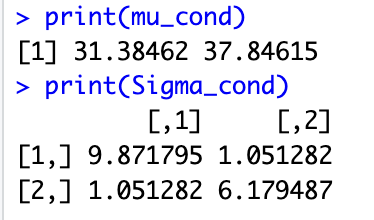
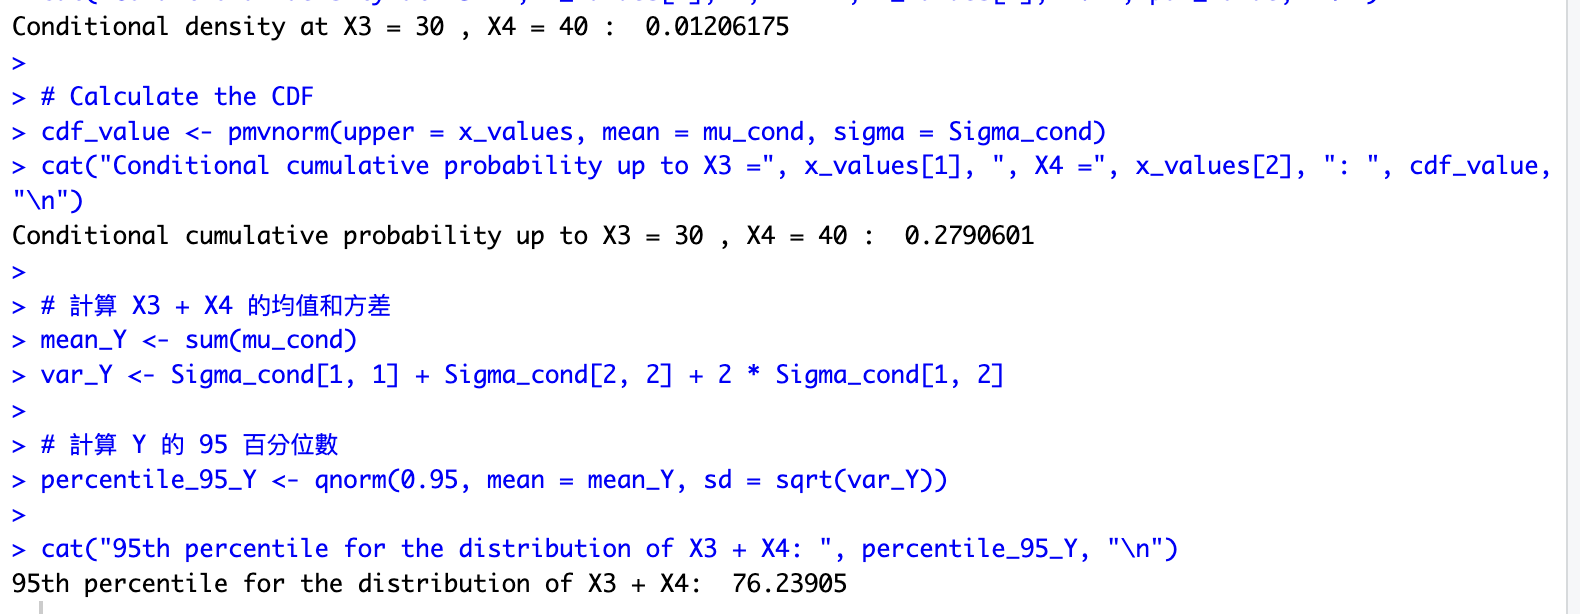


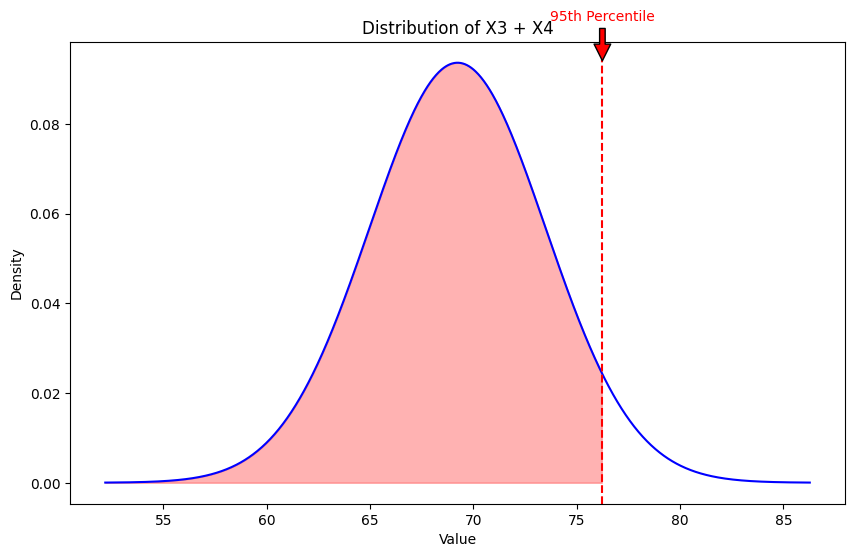

In [56]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


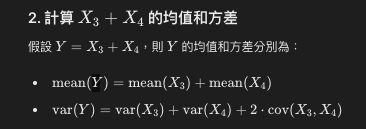


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [57]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.012187295612501
模擬計算的Y的方差: 2.960527573380272


### Calculate Qk hat for 2~T-1 of demand_df_train


In [58]:
demand_df_train = demand_folds[0][0]

In [59]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [60]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [61]:
Qk_hat_df

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9,Qk_hat_k10
0,2650.716711,2642.919994,2645.249082,2638.562853,2642.977079,2642.977079,2633.809066,2628.359222,2628.358955
1,2932.147583,2899.724482,2900.977433,2895.382484,2890.533720,2890.533720,2887.320719,2880.458254,2880.457988
2,2831.437790,2745.150948,2745.135311,2740.169856,2729.021143,2729.021143,2721.707322,2718.872228,2718.871963
3,2830.195355,2796.919097,2797.294809,2792.898196,2785.538066,2785.538066,2788.261071,2786.450146,2786.449880
4,2599.083128,2525.479118,2523.770445,2521.411296,2527.212030,2527.212030,2525.610977,2523.371913,2523.371652
...,...,...,...,...,...,...,...,...,...
175,702.225793,677.083292,678.291523,675.287114,666.068118,666.068118,663.120891,658.039086,658.038822
176,685.369483,633.820340,633.906167,636.223322,634.067275,634.067275,636.327423,635.889133,635.888868
177,647.774137,617.166356,616.391347,620.417599,621.564815,621.564815,618.587994,616.092343,616.092079
178,716.992650,651.599868,652.238037,649.133957,647.663751,647.663750,650.985226,645.046051,645.045776


### Plot the distribuction


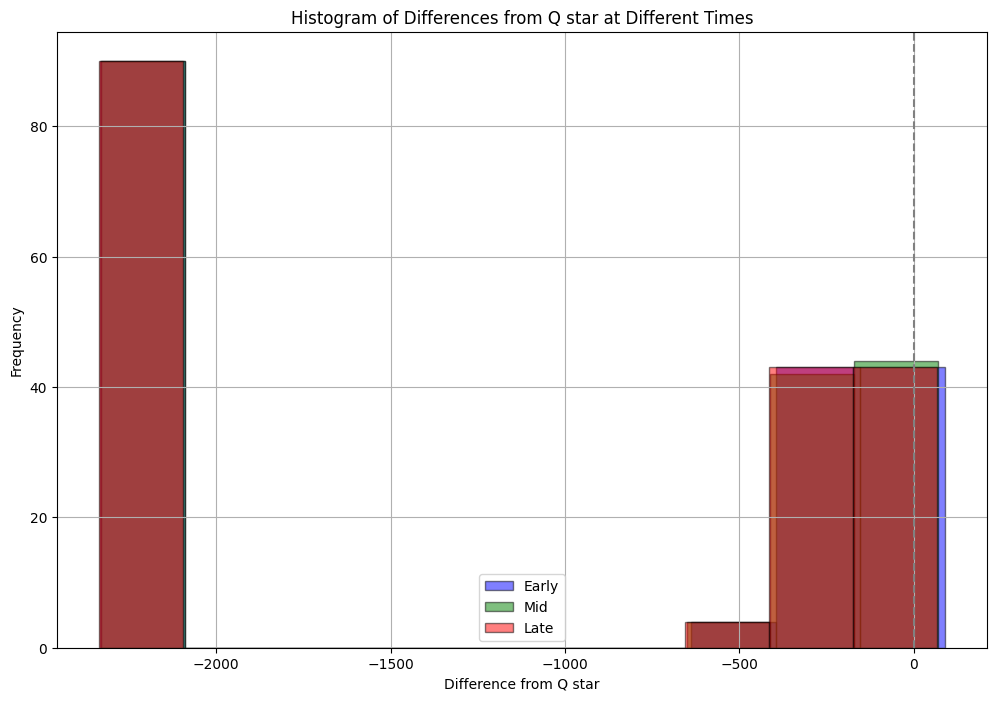

Q_star is: 2935.1990455825025
Early bias: -1211.2530736141
Mid bias: -1227.386006605753
Late bias: -1233.1813366617978


In [62]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

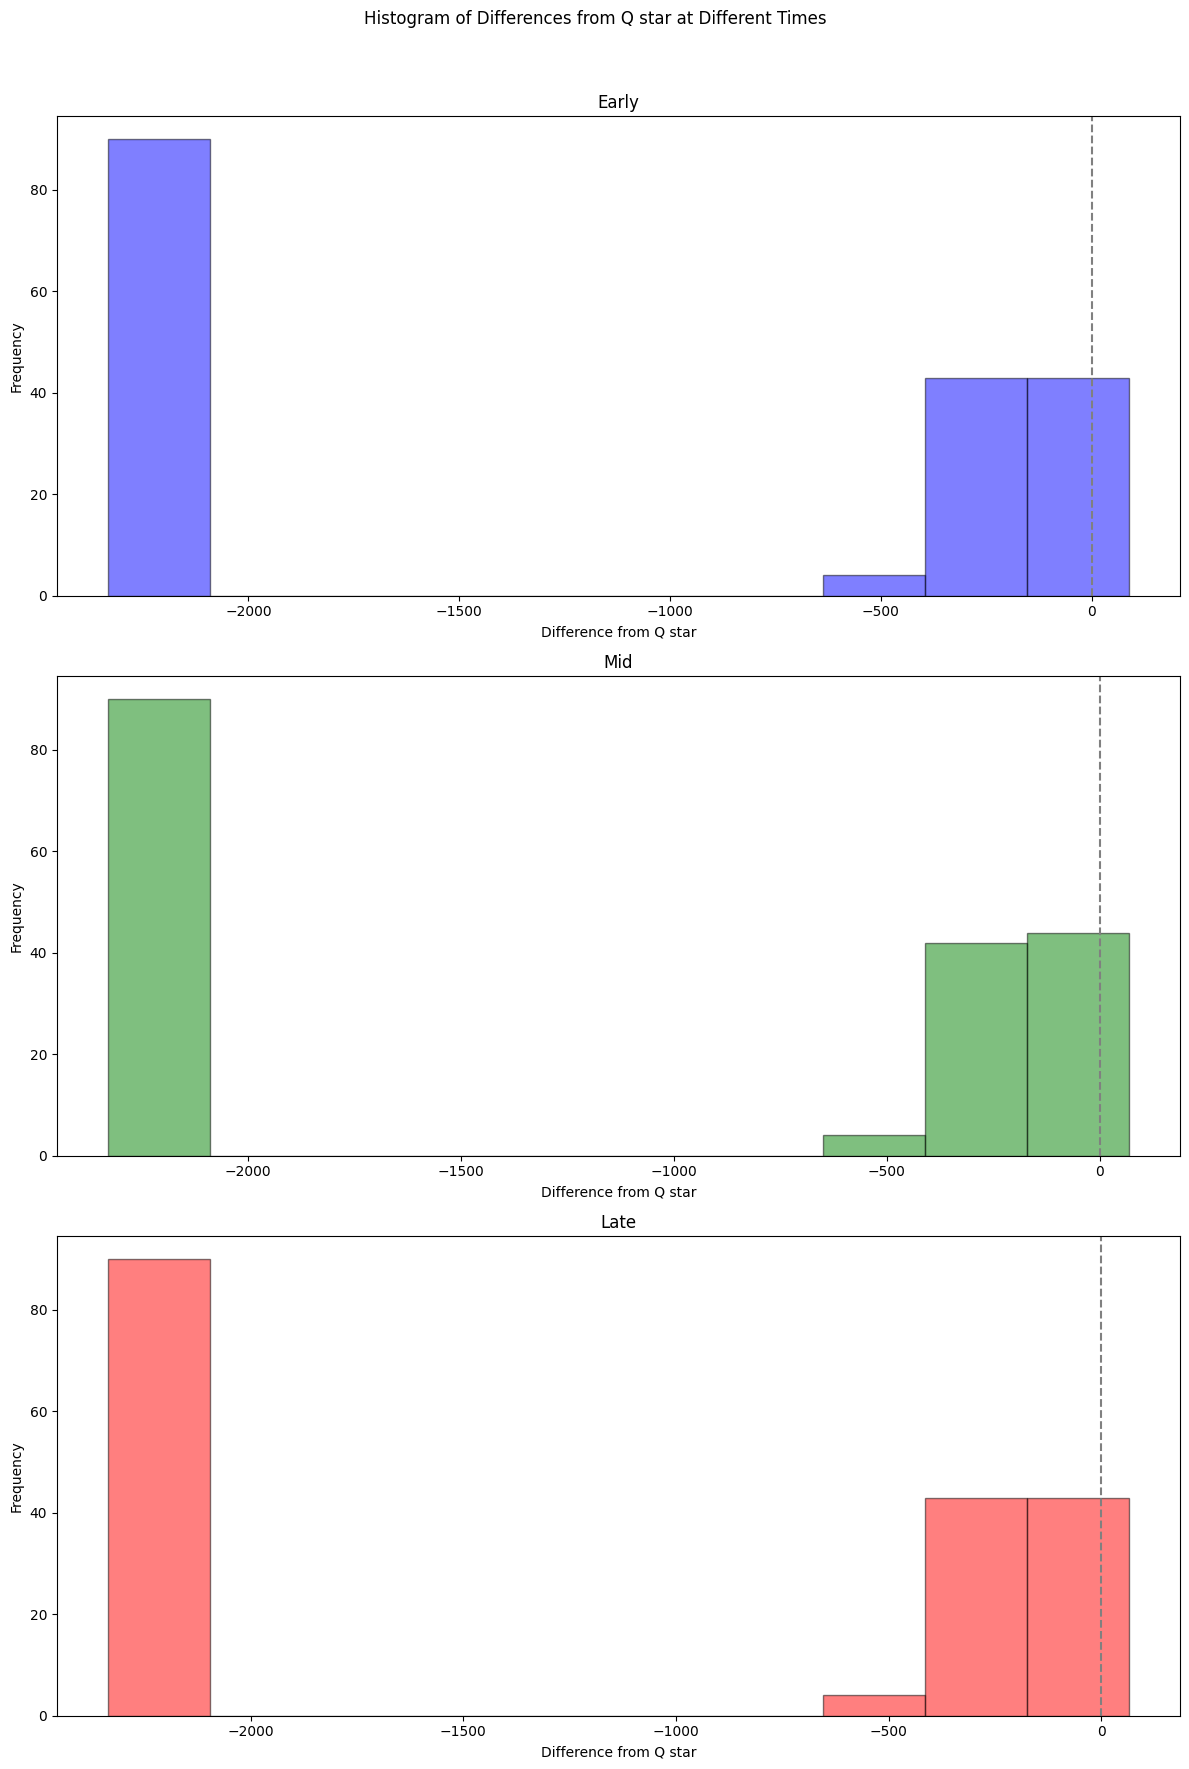

In [63]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

### Validate the r and R

In [64]:
import gurobipy as gp
from gurobipy import GRB

# 初始化模型
# model = gp.Model("Test_r_R_relationship")
model = gp.Model(env=env)

# 設定參數
K = 4  # 候選數量
i = 0  # 單個 i 的例子

# 定義變數
r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# 假設 exp_tau_vars 是已知的輸入數值
exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
for k in range(K):
    model.addConstr(
        r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
        name=f"softmax_relation_{k}",
    )

# 限制式 2: 確保 r_vars 的加總為 1
model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# 限制式 3: 找出 r_vars 中的最大值
model.addGenConstrMax(
    max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
)

# 限制式 4: 確保 R_vars 對應到最大值
for k in range(K):
    model.addGenConstrIndicator(
        R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
    )

# 限制式 5: 確保僅有一個 R_vars[k] 為 1
model.addConstr(
    gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
)

# 設定目標函數（範例：最大化 max_r_helper）
model.setObjective(max_r_helper, GRB.MAXIMIZE)

# 求解模型
model.optimize()

# 輸出結果
if model.Status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"max_r_helper: {max_r_helper.X}")
    print("r_vars:")
    for k in range(K):
        print(f"  r_vars[{k}]: {r_vars[k].X}")
    print("R_vars:")
    for k in range(K):
        print(f"  R_vars[{k}]: {R_vars[k].X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 6 rows, 9 columns and 12 nonzeros
Model fingerprint: 0x2fc3cf89
Model has 5 general constraints
Variable types: 5 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0.454545 
No other solutions better than 0.454545

Optimal solution found (tolerance 1.00e-04)
Best objective 4.5454

檢驗結果：目前的寫法可以成功讓 r 與 R 的關係實現



## S0 - One-time Procurement


In [65]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        # print("=" * 50)
        # print(
        #     f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        # )
        # print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            # print("-" * 50)
            # print(f"Day {day+1}")
            # print(f"Demand      : {demand}")
            # print(f"Sales       : {sales}")
            # print(f"Loss        : {loss}")
            # print(f"Left        : {left}")
            # print(f"Inventory   : {inventory}")
            # print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                # print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                # print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        # print("=" * 50)
        # print(f"Row {i+1} Summary")
        # print(f"Total Sold         : {total_sold}")
        # print(f"Total Lost         : {total_lost}")
        # print(f"Operation Profit   : {operation_profit}")
        # print(f"Profit             : {profit}")
        # print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    # print("=" * 50)
    # print("Overall Summary")
    # print(f"Average Losses           : {avg_losses}")
    # print(f"Average Lefts            : {avg_lefts}")
    # print(f"Average Operation Profits: {avg_operation_profits}")
    # print(f"Average Profits          : {avg_profits}")
    # print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [66]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    # print(f"\n")
    # print(f"====" * 10)
    # print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max((row[: assigned_R + 1].sum() - Q0), 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1
        total_left = left_0 + left_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold

        left_penalty_cost = (cost - salvage_value) * left_1
        # left_penalty_cost = (cost - salvage_value) * total_left
        lost_penalty_cost = (price - cost) * total_lost

        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(total_left)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [67]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            # assigned_R = assigned_T - 1
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                # print(
                #     f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                # )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F(with lasso)


In [68]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_alpha,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("NonConvex", 2)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        abs_alphas = model.addVars(alphas.keys(), lb=0, name="abs_alpha")

        # 進行 L1 正則化處理：alphas
        for i in alphas.keys():
            model.addConstr(abs_alphas[i] >= alphas[i])
            model.addConstr(abs_alphas[i] >= -alphas[i])

        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], options="FuncNonlinear=1"
            )

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_before_R - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_before_R - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_after_R - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_after_R - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # left cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train)))
            - lambda_alpha * gp.quicksum(abs_alphas[i] for i in abs_alphas.keys()),
            GRB.MAXIMIZE,
        )

        model.write("s17_model_debug.lp")
        model.write("s17_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                    "fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X
                    left0 = Left_0s[i].X
                    print(
                        f"Lost0: {lost0}, Lost1: {lost1}, Left0: {left0}, Left1: {left1}"
                    )

                    # Record results
                    results["losses"].append(lost0 + lost1)

                    # results["lefts"].append(left1)
                    results["lefts"].append(left0 + left1)

                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)

                    # Check f
                    x_data = training_df.iloc[i].tolist()
                    x_data.append(1)
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )
                    print(
                        f"f_train: {f_train}, F_train: {F_train}, Q0_train: {Q0_train}"
                    )
                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        print("f_train, F_train, Q0_train 都相等")
                        results["Q0s"].append(Q0_vars[i].X)
                        results["Fs"].append(F_vars[i].X)
                        results["fs"].append(f_vars[i].X)
                    else:
                        print(f"f_train, F_train, Q0_train 不相等")
                        results["Q0s"].append(-1)
                        results["Fs"].append(-1)
                        results["fs"].append(-1)
                        # results["Q0s"].append(Q0_vars[i].X)
                        # results["Fs"].append(F_vars[i].X)
                        # results["fs"].append(f_vars[i].X)
                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [69]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "f_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        # assigned_R = assigned_T - 1

        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            lambda_alpha=LASSO_ALPHA,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            f_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["f_vars"].append(f_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        # print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            # print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "f": f_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S14 - Optimized F & Rk

In [70]:
def __cal_optimized_F_R(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
        # K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # left cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                # all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [71]:
def cal_optimized_F_R(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df,
    Qk_hat_df,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    (
        all_Rs,
        losses,
        lefts,
        profits,
        operation_profits,
        F_vars,
        Q0_vars,
        Q1_vars,
        all_holding_costs_0,
        all_holding_costs_1,
        all_left0s,
        all_left1s,
        all_lost0s,
        all_lost1s,
    ) = __cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    # 計算平均值
    average_losses = sum(losses) / len(losses) if losses else 0
    average_lefts = sum(lefts) / len(lefts) if lefts else 0
    average_profits = sum(profits) / len(profits) if profits else 0
    average_operation_profits = (
        sum(operation_profits) / len(operation_profits) if operation_profits else 0
    )

    # 將結果存儲到字典中
    results_dict["R(T)"].append(all_Rs)
    results_dict["average_losses"].append(average_losses)
    results_dict["average_lefts"].append(average_lefts)
    results_dict["average_profits"].append(average_profits)
    results_dict["average_operation_profits"].append(average_operation_profits)
    results_dict["alpha_values"].append(None)
    results_dict["F_vars"].append(F_vars)
    results_dict["Q0_vars"].append(Q0_vars)
    results_dict["Q1_vars"].append(Q1_vars)

    # print(f"The average profits is {average_profits}")

    if max_profit is None or max_profit < average_profits:
        # print(f"max_profit is changed from {max_profit} to {average_profits}")
        max_profit = average_profits
        max_profit_stimulation_result = {
            "R": all_Rs,
            "F": F_vars,
            "profits": profits,
            "losses": losses,
            "lefts": lefts,
            "operation_profits": operation_profits,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S12 - Beta without r

In [72]:
def __fully_flexible_beta_with_softmax_12(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
        # K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i],
                yvar=F_vars[i],
                options="FuncNonlinear=1",
                name=f"logistic_constraint_{i}",
            )

            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                # 如果候選 k 未被選中 (R_vars[i,k] == 0)，則必須有 tau_vars[i,k] <= tau_star - delta
                # 利用 Big-M 技巧：當 R_vars[i,k]==0 時，約束變為 tau_vars[i,k] <= tau_star - delta
                # 當 R_vars[i,k]==1 時，由於前面的 indicator 約束已強制 tau_vars[i,k] == tau_star，
                # 此約束則不會影響模型（因為 tau_star <= tau_star - delta + M 已經成立）
                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # left cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )
        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)

                    all_Q1s.append(Q1_vars[i].X)
                    # all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    # Check f
                    x_data = training_df.iloc[i].tolist()
                    x_data.append(1)
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )
                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        print("f_train, F_train, Q0_train 都相等")
                        all_Q0s.append(Q0_vars[i].X)
                        all_Fs.append(F_vars[i].X)
                    else:
                        print(f"f_train, F_train, Q0_train 不相等")
                        all_Q0s.append(-1)
                        all_Fs.append(-1)
                        # results["Q0s"].append(Q0_vars[i].X)
                        # results["Fs"].append(F_vars[i].X)
                        # results["fs"].append(f_vars[i].X)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [73]:
def fully_flexible_beta_with_softmax_12(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_12(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [74]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):
    assigned_R = assigned_T - 2
    # assigned_R = assigned_T - 1
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [75]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    # K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        print(f"f_vars[i]: {f_vars[i]}, F_vars[i]: {F_vars[i]}")
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
        )

        # profits_vars[i] = (
        #     (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
        #     - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
        #     - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # 加上 Left_0s[i]
        # )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss_penalty": [
                np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))
            ],
            "average_left_penalty": [
                np.mean((cost - salvage_value) * (Left_0s[i] + Left_1s[i]))
            ],
            "average_loss": [np.mean((Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((Left_0s[i] + Left_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S12 - Beta without r

In [76]:
def cal_test_fully_flexible_beta_with_softmax_12(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    # K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        print(f"tau: {tau_vars[i]}")
        print(f"R: {R_vars[i]}")
        print(f"max_r_index: {max_r_index[i]}")
        print("\n\n")

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        # profits_vars[i] = (
        #     (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
        #     - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
        #     - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * (Left_1s[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# MAIN


## Setting reasonable parameters


In [77]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202508191608

In [78]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.6


In [79]:
# training_df, testing_df = training_data_folds[0]
# demand_df_train, demand_df_test = demand_folds[0]

In [80]:
# training_df

In [81]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,260.665332,263.227780,256.612851,263.227781,270.395186,263.227781,262.959187,261.587350,263.227781,263.227781
1,288.757548,288.711684,285.892907,288.711684,287.950668,288.711684,289.755310,284.542984,288.711684,288.711684
2,278.704773,272.807517,275.426989,272.807517,264.746244,272.807517,266.943818,269.012408,272.807517,272.807517
3,278.580754,278.421697,277.869368,278.421697,275.329949,278.421697,282.195725,280.365448,278.421697,278.421697
4,255.511307,250.939491,257.341987,250.939490,254.054255,250.939490,248.382853,253.383650,250.939490,250.939490
5,283.352806,280.881775,282.665541,280.881775,276.736838,280.881775,281.435630,280.678803,280.881775,280.881775
6,282.319477,280.604786,282.434873,280.604786,276.519313,280.604786,281.091755,283.311837,280.604786,280.604786
7,277.114393,280.846700,277.344745,280.846700,279.442374,280.846700,281.231984,281.149643,280.846700,280.846700
8,299.964518,297.187404,296.829399,297.187404,290.833791,297.187404,295.878264,295.144133,297.187404,297.187404
9,286.436749,284.091015,283.616635,284.091015,284.154231,284.091015,284.088444,279.789453,284.091015,284.091015


In [82]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 2725.179144602332
std of sum: 127.68303363832797
60.0 percentile of sum: 2757.5272712941933
Q_star: 2757.5272712941933


In [83]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9,Qk_hat_k10
0,2621.034777,2632.336554,2628.259325,2628.259325,2633.227085,2633.227085,2628.465051,2628.358808,2628.358808
1,2875.042955,2886.262064,2884.557379,2884.557378,2883.624078,2883.624077,2883.071598,2880.457841,2880.457840
2,2784.146349,2731.919767,2731.326881,2731.326880,2724.726066,2724.726066,2719.442900,2718.871815,2718.871815
3,2783.024977,2784.375024,2783.865009,2783.865008,2780.050061,2780.050061,2784.505468,2786.449732,2786.449732
4,2574.432384,2514.527363,2516.337643,2516.337642,2523.813694,2523.813694,2522.558905,2523.371503,2523.371503
5,2826.173588,2810.025033,2810.335622,2810.335622,2807.402434,2807.402434,2808.973882,2809.278491,2809.278491
6,2816.830292,2806.863154,2807.469565,2807.469565,2804.221450,2804.221450,2805.927881,2808.701185,2808.701185
7,2769.766230,2806.252672,2805.217767,2805.217766,2800.650308,2800.650307,2800.225635,2800.516639,2800.516639
8,2976.375716,2971.744398,2970.968725,2970.968725,2965.580653,2965.580653,2964.017741,2964.587125,2964.587125
9,2854.058423,2841.751866,2840.671735,2840.671735,2842.610137,2842.610137,2841.385898,2838.540587,2838.540587


## K-folds training

### Pre-Settings

In [84]:
len(training_data_folds), len(demand_folds)

(3, 3)

### Training & Testing Function 

In [85]:
# This is for single fold training.
def perform_fold_training(
    training_df, demand_df_train, Qk_hat_df_train, Q_star
) -> dict[str, float]:

    # 1. Baseline model
    (
        baseline_avg_losses,
        baseline_avg_lefts,
        baseline_avg_profits,
        baseline_avg_operation_profits,
        baseline_stimulation_df,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_train,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    # 2. S1 - Grid F & Grid R

    results_df_1, stimulation_results_df_1 = None, None

    results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        assigned_Fs=ASSIGNED_FS,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
        Qk_hat_df=Qk_hat_df_train,
        demand_df_train=demand_df_train,
        Q_star=Q_star,
    )

    S1_profit_training = results_df_1.iloc[0]["average_profits"]

    # 3. S2 - Grid R & Flexible F

    results_df_2, stimulation_results_df_2 = None, None
    results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df_train=Qk_hat_df_train,
        training_df=training_df,
    )

    S2_profit_training = results_df_2.iloc[0]["average_profits"]

    # 4. S12 - Beta without r
    results_df_12, stimulation_results_df_12 = None, None
    results_df_12, stimulation_results_df_12 = fully_flexible_beta_with_softmax_12(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    if results_df_12 is not None:
        S12_profit_training = results_df_12.iloc[0]["average_profits"]
    else:
        S12_profit_training = None

    # 5. S14 - Optimized F & Rk
    results_df_14, stimulation_results_df_14 = None, None
    results_df_14, stimulation_results_df_14 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    S14_profit_training = results_df_14.iloc[0]["average_profits"]

    # 整理利潤結果
    training_profits = {
        "baseline": baseline_avg_profits,
        "S1": S1_profit_training,
        "S2": S2_profit_training,
        "S12": S12_profit_training,
        "S14": S14_profit_training,
    }

    training_results = {
        "S1": results_df_1,
        "S2": results_df_2,
        "S12": results_df_12,
        "S14": results_df_14,
    }

    training_stimulation_results = {
        "baseline": baseline_stimulation_df,
        "S1": stimulation_results_df_1,
        "S2": stimulation_results_df_2,
        "S12": stimulation_results_df_12,
        "S14": stimulation_results_df_14,
    }

    return training_profits, training_results, training_stimulation_results

In [86]:
# This is for single fold testing.


def perform_fold_testing(
    results_df_1,
    results_df_2,
    results_df_12,
    demand_df_test,
    Qk_hat_df_test,
    Q_star,
    testing_df,
) -> dict[str, float]:

    # 1. Baseline model

    (
        test_baseline_avg_loss,
        test_baseline_avg_lefts,
        test_baseline_avg_profits,
        test_baseline_avg_operation_profits,
        test_stimulation_df_baseline,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_test,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    print(f"baseline_profit: {test_baseline_avg_profits}")

    # 2. S1 - Grid F & Grid R
    if results_df_1 is not None:
        assigned_T = results_df_1.iloc[0]["R(T)"]
        assigned_F = results_df_1.iloc[0]["F"]

        test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
        )

    S1_profit_testing = test_results_df_1.iloc[0]["average_profits"]

    # 3. S2 - Grid R & Flexible F

    if results_df_2 is not None and len(results_df_2) > 0:
        assigned_R = results_df_2.iloc[0]["R"]
        alphas = results_df_2.iloc[0]["alpha_values"]

        test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
            assigned_R=assigned_R[0],
            alphas=alphas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )

    S2_profit_testing = test_results_df_2.iloc[0]["average_profits"]

    # 4. S12 - Beta without r
    test_results_df_12, test_stimulation_results_df_12 = None, None
    if results_df_12 is not None:
        alphas = results_df_12.iloc[0]["alpha_values"]
        betas = results_df_12.iloc[0]["beta_values"]

        test_results_df_12, test_stimulation_results_df_12 = (
            cal_test_fully_flexible_beta_with_softmax_12(
                alphas=alphas,
                betas=betas,
                salvage_value=salvage_value,
                cost=cost,
                price=price,
                Q_star=Q_star,
                demand_df_test=demand_df_test,
                Qk_hat_df_test=Qk_hat_df_test,
                testing_df=testing_df,
            )
        )
        S12_profit_testing = test_results_df_12.iloc[0]["average_profits"]
    else:
        S12_profit_testing = None

    # 5. S14 - Optimized F & Rk
    test_results_df_14, test_stimulation_results_df_14 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_test,
        Qk_hat_df=Qk_hat_df_test,
        training_df=testing_df,
    )

    S14_profit_testing = test_results_df_14.iloc[0]["average_profits"]

    # 整理利潤結果
    testing_profits = {
        "baseline": test_baseline_avg_profits,
        "S1": S1_profit_testing,
        "S2": S2_profit_testing,
        "S12": S12_profit_testing,
        "S14": S14_profit_testing,
    }

    testing_stimulation_results = {
        "baseline": test_stimulation_df_baseline,
        "S1": test_stimulation_results_df_1,
        "S2": test_stimulation_results_df_2,
        "S12": test_stimulation_results_df_12,
        "S14": test_stimulation_results_df_14,
    }

    return testing_profits, testing_stimulation_results

### Main

In [87]:
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    print(f"training_df: \n{training_df}")
    print(f"demand_df_train: \n{demand_df_train}")
    print(f"testing_df: \n{testing_df}")
    print(f"demand_df_test: \n{demand_df_test}")

===== Processing Fold 1 =====
training_df: 
           X1   X2          X3
0   17.744068  0.0  263.227781
1   18.575947  0.0  288.711684
2   18.013817  0.0  272.807517
3   17.724416  0.0  278.421697
4   17.118274  0.0  250.939490
5   18.229471  0.0  280.881775
6   17.187936  0.0  280.604786
7   19.458865  0.0  280.846700
8   19.818314  0.0  297.187404
9   16.917208  0.0  284.091015
10  18.958625  0.0  267.975395
11  17.644475  0.0  271.851598
12  17.840223  0.0  284.881560
13  19.627983  0.0  253.011274
14  15.355180  0.0  283.338336
15  15.435646  0.0  283.531893
16  15.101092  0.0  260.519128
17  19.163099  0.0  256.446315
18  18.890784  0.0  265.771418
19  19.350061  0.0  268.185539
20  19.893092  0.0  278.509839
21  18.995793  0.0  271.930076
22  17.307397  0.0  299.418692
23  18.902646  0.0  255.102241
24  15.591372  0.0  260.443838
25  18.199605  0.0  258.065476
26  15.716766  0.0  282.655416
27  19.723345  0.0  262.664580
28  17.609242  0.0  273.315539
29  17.073310  0.0  262.22

In [88]:
train_all_fold_profits = []
train_all_fold_stimulation_results = []
test_all_fold_profits = []
test_all_fold_stimulation_results = []
beta_records = {"S12": [], "S15": [], "S16": []}

# 迴圈遍歷所有 fold
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    # ====訓練階段====

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
    Qk_hat_df_train = make_Qk_hat_df(
        demand_df_train, T, service_lv, mu_matrix, covariance_matrix
    )
    training_profits, training_results, training_stimulation_results = (
        perform_fold_training(training_df, demand_df_train, Qk_hat_df_train, Q_star)
    )
    train_all_fold_profits.append(training_profits)
    train_all_fold_stimulation_results.append(training_stimulation_results)

    # if training_results["S12"] is not None:
    #     beta_records["S12"].append(training_results["S12"].iloc[0]["beta_values"])
    # else:
    #     beta_records["S12"].append(None)

    # if training_results["S15"] is not None:
    #     beta_records["S15"].append(training_results["S15"].iloc[0]["beta_values"])
    # else:
    #     beta_records["S15"].append(None)

    # if training_results["S16"] is not None:
    #     beta_records["S16"].append(training_results["S16"].iloc[0]["beta_values"])
    # else:
    #     beta_records["S16"].append(None)

    for key in ["S12", "S15", "S16"]:
        result = training_results.get(key)  # 如果 key 不存在，直接回傳 None
        if result is not None:
            beta_records[key].append(result.iloc[0]["beta_values"])
        else:
            beta_records[key].append(None)

    # ====測試階段====
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
    Qk_hat_df_test = make_Qk_hat_df(
        demand_df_test, T, service_lv, mu_matrix, covariance_matrix
    )
    testing_profits, testing_stimulation_results = perform_fold_testing(
        training_results["S1"],
        training_results["S2"],
        training_results["S12"],
        demand_df_test,
        Qk_hat_df_test,
        Q_star,
        testing_df,
    )

    test_all_fold_profits.append(testing_profits)
    test_all_fold_stimulation_results.append(testing_stimulation_results)


# 將所有 fold 的結果轉換為 DataFrame 便於檢查與保存
train_all_fold_profit_df = pd.DataFrame(train_all_fold_profits)
print("All train fold profits:")
print(train_all_fold_profit_df)

test_all_fold_profit_df = pd.DataFrame(test_all_fold_profits)
print("All test fold profits:")
print(test_all_fold_profit_df)

===== Processing Fold 1 =====
mean of sum: 2725.179144602332
std of sum: 127.68303363832797
60.0 percentile of sum: 2757.5272712941933
Fold 1 Q_star: 2757.5272712941933
+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 338 rows, 518 columns and 886 nonzeros
Model fingerprint: 0x2604e9ee
Model has 240 general constraints
Variable types: 518 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3098193758.py:157: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


* 7178  3360             205    4.892203e+07 4.9053e+07  0.27%   6.2    1s

Cutting planes:
  Implied bound: 8

Explored 8245 nodes (49532 simplex iterations) in 1.54 seconds (1.94 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 4.8922e+07 4.83502e+07 -1.97264e+07 

Optimal solution found (tolerance 1.00e-02)
Best objective 4.892203196989e+07, best bound 4.905322460160e+07, gap 0.2682%

model.status is optimal: True
model.status is TIME_LIMIT: False

f_vars[i]: 3.0139, F_vars[i]: 0.9532, Q0_vars[i]: 2628.4651
f_train, F_train, Q0_train 都相等
第 2 天補貨策略: R_vars = -0.0, tau_vars = -1.6420094325758585
第 3 天補貨策略: R_vars = -0.0, tau_vars = -1.8131255204055636
第 4 天補貨策略: R_vars = -0.0, tau_vars = -1.6187176909545649
第 5 天補貨策略: R_vars = -0.0, tau_vars = -9.33600388025616
第 6 天補貨策略: R_vars = -0.0, tau_vars = -1.7072576985907206
第 7 天補貨策略: R_vars = -0.0, tau_vars = -0.8404802009014347
第 8 天補貨策略: R_vars = 1.0, tau_vars = -0.8394802009014347
第 9 天補貨策略: R_vars = -0.0, 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/98950305.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)

Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 870 columns and 1890 nonzeros
Model fingerprint: 0x558f55da
Model has 210 general constraints
Variable types: 630 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 277 rows and 584 columns
Presolve time: 0.04s
Presolved: 143 rows, 286 columns, 767 nonzeros
Presolved model has 39 SOS constraint(s)
Variable types: 143 continuous, 143 integer (143 binary)

Root relaxation: objective 1.177856e+07, 68 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     O

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/98950305.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 338 rows, 518 columns and 886 nonzeros
Model fingerprint: 0xfd157dc0
Model has 240 general constraints
Variable types: 518 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [3e+02, 3e+03]
Presolve removed 119 row

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3098193758.py:157: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


*11700  3825             180    4.903407e+07 4.9289e+07  0.52%   5.9    2s

Cutting planes:
  Cover: 3
  Implied bound: 11

Explored 12232 nodes (73274 simplex iterations) in 2.37 seconds (2.60 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 4.90341e+07 

Optimal solution found (tolerance 1.00e-02)
Best objective 4.903406803701e+07, best bound 4.928935482741e+07, gap 0.5206%

model.status is optimal: True
model.status is TIME_LIMIT: False

f_vars[i]: 2.9060, F_vars[i]: 0.9481, Q0_vars[i]: 2635.4669
f_train, F_train, Q0_train 都相等
第 2 天補貨策略: R_vars = -0.0, tau_vars = -0.2509567990837285
第 3 天補貨策略: R_vars = -0.0, tau_vars = -0.07266115502372952
第 4 天補貨策略: R_vars = -0.0, tau_vars = -0.0029423251380192765
第 5 天補貨策略: R_vars = -0.0, tau_vars = -0.2188233070822263
第 6 天補貨策略: R_vars = -0.0, tau_vars = -0.002942325138019279
第 7 天補貨策略: R_vars = -0.0, tau_vars = -0.0029423251380192787
第 8 天補貨策略: R_vars = -0.0, tau_vars = -0.008649407131891435
第 9 天補貨策略: R_vars = 1.0

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/98950305.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/4099219363.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/798153165.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 420 rows, 870 columns and 1890 nonzeros
Model fingerprint: 0xd93f122d
Model has 210 general constraints
Variable types: 630 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 343 rows and 716 columns
Presolve time: 0.14s
Presolved: 77 rows, 154 columns, 413 nonzeros
Presolved model has 21 SOS constraint(s)
Variable types: 77 continuous, 77 integer (77 binary)

Root relaxation: objective 1.163860e+07, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 338 rows, 518 columns and 886 nonzeros
Model fingerprint: 0x7174a00d
Model has 240 general constraints
Variable types: 518 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [2e+02, 3e+03]
Presolve removed 112 row

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3098193758.py:157: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


* 7836  4040             194    4.948137e+07 5.0280e+07  1.61%   7.0    1s
H 9100  4108                    4.978785e+07 5.0280e+07  0.99%   6.7    1s

Cutting planes:
  Cover: 2
  Implied bound: 11

Explored 10158 nodes (66071 simplex iterations) in 1.93 seconds (2.32 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 4.97879e+07 4.94814e+07 

Optimal solution found (tolerance 1.00e-02)
Best objective 4.978785294889e+07, best bound 5.027978648668e+07, gap 0.9881%

model.status is optimal: True
model.status is TIME_LIMIT: False

f_vars[i]: 6.4478, F_vars[i]: 0.9984, Q0_vars[i]: 2830.1103
f_train, F_train, Q0_train 都相等
第 2 天補貨策略: R_vars = 0.0, tau_vars = -0.0013147970090491151
第 3 天補貨策略: R_vars = 0.0, tau_vars = -0.11736081183024605
第 4 天補貨策略: R_vars = 0.0, tau_vars = -0.02088625684011869
第 5 天補貨策略: R_vars = 0.0, tau_vars = 0.025804868448040807
第 6 天補貨策略: R_vars = 0.0, tau_vars = -0.017494659086197108
第 7 天補貨策略: R_vars = 0.0, tau_vars = -0.025014155532073784


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/98950305.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_21451/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)

Optimize a model with 420 rows, 870 columns and 1890 nonzeros
Model fingerprint: 0xb0853b4c
Model has 210 general constraints
Variable types: 630 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 277 rows and 584 columns
Presolve time: 0.05s
Presolved: 143 rows, 286 columns, 767 nonzeros
Presolved model has 39 SOS constraint(s)
Variable types: 143 continuous, 143 integer (143 binary)

Root relaxation: objective 1.163441e+07, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.1634e+07    0   14          - 1.1634e+07      -     -    0s
H    0     0                    1.163046e+07 1.1634e+07  0.03%     -    0s

Explored 1 nodes (79 simplex iterations) in 0.07 seconds (

In [89]:
train_all_fold_profit_df

,baseline,S1,S2,S12,S14
0,1.559907e+06,1.635107e+06,1.635107e+06,1.630734e+06,1.635103e+06
1,1.541905e+06,1.642967e+06,1.640440e+06,1.634469e+06,1.642892e+06
2,1.575879e+06,1.675420e+06,1.675993e+06,1.659595e+06,1.675934e+06


In [90]:
test_all_fold_profit_df

,baseline,S1,S2,S12,S14
0,-448646.594511,-338345.503659,213070.923484,181771.793928,392618.588404
1,-465256.782986,-354072.230445,90665.979721,-27612.683356,387953.245442
2,-487480.949243,-374097.217198,-23729.660804,179583.288610,387681.837719


In [91]:
beta_records

{'S12': [array([[ 8.16399716e-01,  0.00000000e+00, -4.63923580e-02,
          -3.91650367e+00],
         [ 5.47234195e-01,  0.00000000e+00, -1.06484704e-01,
           1.65064462e+01],
         [ 7.97695906e-01,  0.00000000e+00, -4.67240795e-02,
          -3.47401195e+00],
         [ 4.69221590e+00,  0.00000000e+00, -8.48872750e-02,
          -7.02503107e+01],
         [ 8.49602044e-01,  0.00000000e+00, -4.37852215e-02,
          -5.25716707e+00],
         [-2.35382734e-01,  0.00000000e+00,  1.26740685e-02,
           0.00000000e+00],
         [-2.38082189e-01,  0.00000000e+00,  1.28232842e-02,
           9.62160437e-03],
         [-2.45637001e-01,  0.00000000e+00,  1.40076361e-02,
          -1.80045689e-01]]),
  array([[-1.85160103e-01,  0.00000000e+00, -1.22733827e-02,
           6.35794301e+00],
         [-5.68156259e-02,  0.00000000e+00, -3.91917030e-03,
           1.99468036e+00],
         [-3.70642881e-04,  0.00000000e+00,  1.92695196e-05,
          -1.00000000e-03],
         [-1

### Analysis

#### Plot

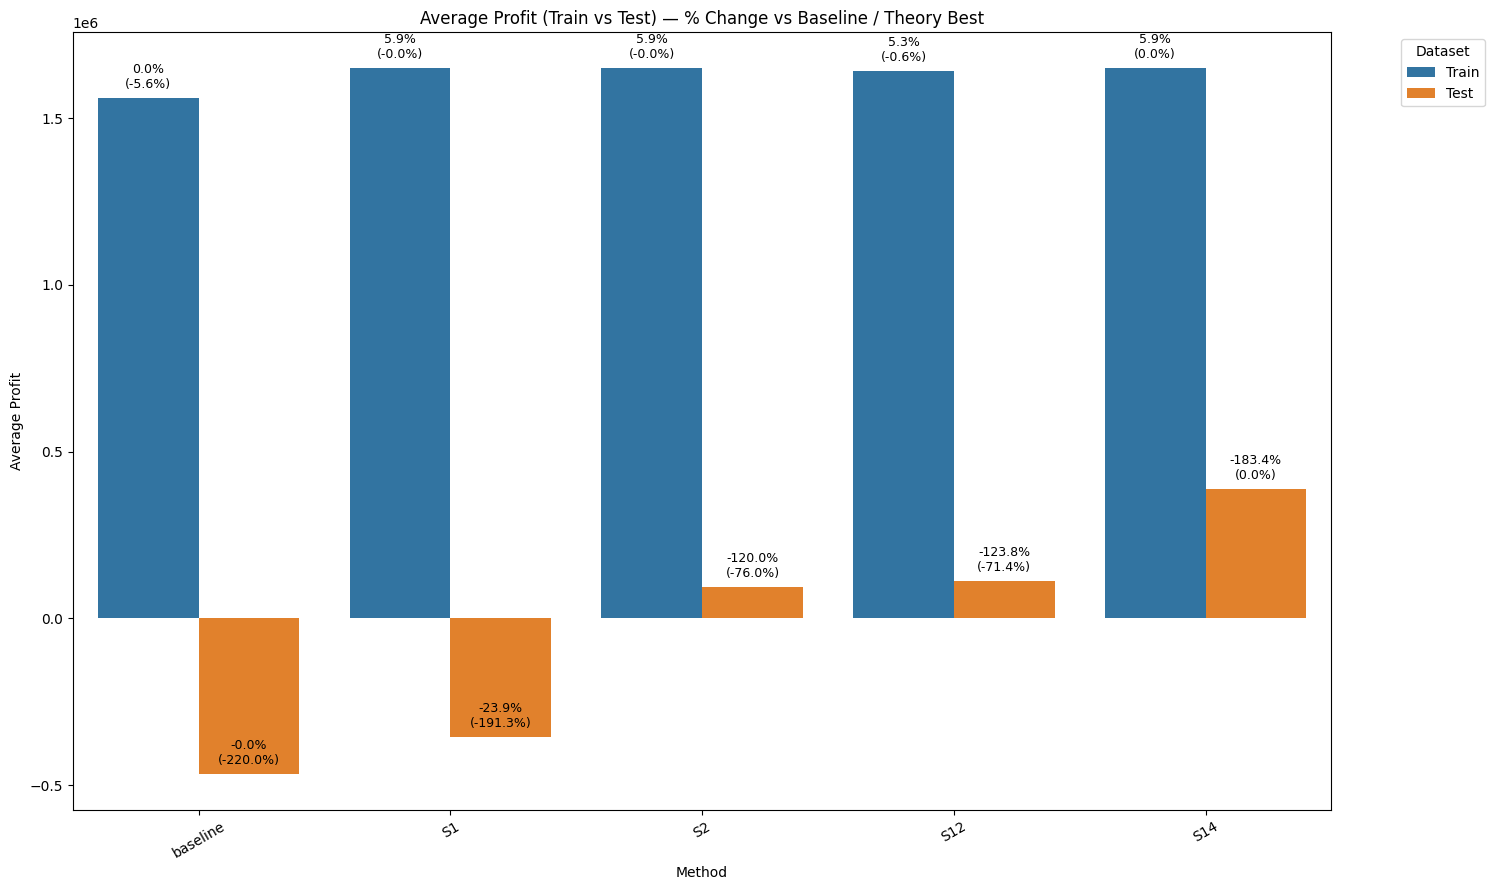

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train_all_fold_profit_df = train_all_fold_profit_df.drop(columns=["S12", "S15", "S16"])
# test_all_fold_profit_df = test_all_fold_profit_df.drop(columns=["S12", "S15", "S16"])

# train_all_fold_profit_df = train_all_fold_profit_df.drop(columns=["S15", "S16"])
# test_all_fold_profit_df = test_all_fold_profit_df.drop(columns=["S15", "S16"])

# 1️⃣ 計算平均 profit
train_means = train_all_fold_profit_df.mean()
test_means = test_all_fold_profit_df.mean()

# 2️⃣ 定義 baseline & theory best
baseline_train = train_means["baseline"]
baseline_test = test_means["baseline"]
theory_best_train = train_means["S14"]
theory_best_test = test_means["S14"]

# 3️⃣ 計算百分比變化：baseline & theory
train_pct_base = (train_means - baseline_train) / baseline_train * 100
test_pct_base = (test_means - baseline_test) / baseline_test * 100
train_pct_theory = (train_means - theory_best_train) / theory_best_train * 100
test_pct_theory = (test_means - theory_best_test) / theory_best_test * 100

# 4️⃣ 建 DataFrame
avg_df = pd.DataFrame(
    {
        "Method": train_means.index,
        "Train": train_means.values,
        "Test": test_means.values,
        "Train_%_Base": train_pct_base.values,
        "Test_%_Base": test_pct_base.values,
        "Train_%_Theory": train_pct_theory.values,
        "Test_%_Theory": test_pct_theory.values,
    }
)

avg_df_melted = avg_df.melt(
    id_vars=[
        "Method",
        "Train_%_Base",
        "Test_%_Base",
        "Train_%_Theory",
        "Test_%_Theory",
    ],
    value_vars=["Train", "Test"],
    var_name="Dataset",
    value_name="Average Profit",
)

# 5️⃣ 畫圖
plt.figure(figsize=(15, 9))
ax = sns.barplot(x="Method", y="Average Profit", hue="Dataset", data=avg_df_melted)

# 6️⃣ 標註：baseline (%) 在第一行、theory (%) 括號內第二行
for patch, (method, ds) in zip(
    ax.patches, zip(avg_df_melted["Method"], avg_df_melted["Dataset"])
):
    if ds == "Train":
        pct_base = avg_df.loc[avg_df.Method == method, "Train_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Train_%_Theory"].values[0]
    else:
        pct_base = avg_df.loc[avg_df.Method == method, "Test_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Test_%_Theory"].values[0]

    ax.annotate(
        f"{pct_base:.1f}%\n({pct_theory:.1f}%)",
        (patch.get_x() + patch.get_width() / 2, patch.get_height()),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.title("Average Profit (Train vs Test) — % Change vs Baseline / Theory Best")
plt.ylabel("Average Profit")
plt.xlabel("Method")
plt.xticks(rotation=30)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

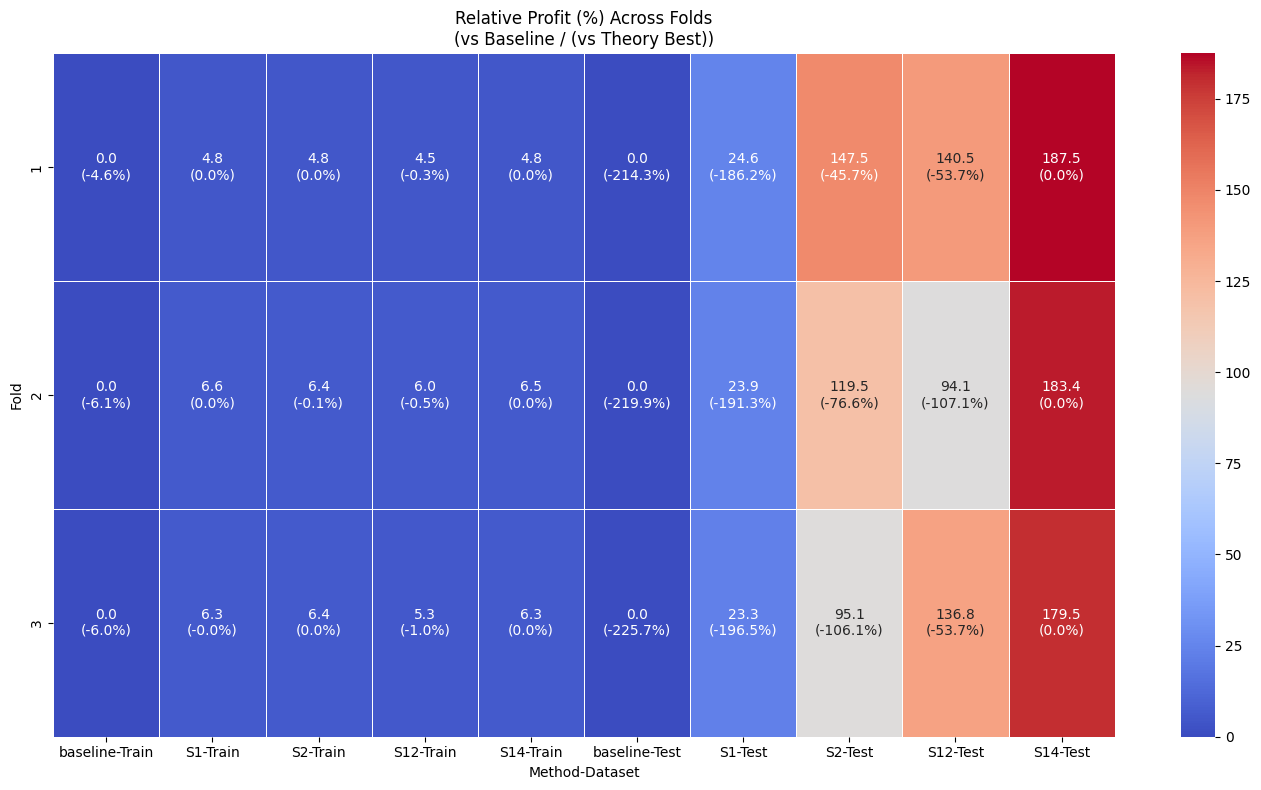

In [93]:
# 計算 baseline（訓練與測試）
baseline_train = train_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)
baseline_test = test_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)

# # 計算百分比變化
# train_relative = (
#     (train_all_fold_profit_df.to_numpy() - baseline_train) / baseline_train * 100
# )
# test_relative = (
#     (test_all_fold_profit_df.to_numpy() - baseline_test) / baseline_test * 100
# )

train_relative = (
    (train_all_fold_profit_df.to_numpy() - baseline_train)
    / np.abs(baseline_train)
    * 100
)
test_relative = (
    (test_all_fold_profit_df.to_numpy() - baseline_test) / np.abs(baseline_test) * 100
)

# 轉回 DataFrame，並保留 column names
train_relative = pd.DataFrame(
    train_relative,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
test_relative = pd.DataFrame(
    test_relative,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)

# 加入 fold 編號
train_relative["Fold"] = train_relative.index + 1
test_relative["Fold"] = test_relative.index + 1

# 轉換成長格式
train_long = train_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
train_long["Dataset"] = "Train"

test_long = test_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
test_long["Dataset"] = "Test"

# 合併數據
fold_long = pd.concat([train_long, test_long], axis=0)

# 3️⃣ Heatmap：同時顯示 vs Baseline & vs Theory Best（每 Fold 的 S14）
theory_best_train = train_all_fold_profit_df["S14"].to_numpy().reshape(-1, 1)
theory_best_test = test_all_fold_profit_df["S14"].to_numpy().reshape(-1, 1)

# vs Theory (%) 計算
# train_theory_rel = (
#     (train_all_fold_profit_df.to_numpy() - theory_best_train) / theory_best_train * 100
# )
# test_theory_rel = (
#     (test_all_fold_profit_df.to_numpy() - theory_best_test) / theory_best_test * 100
# )
train_theory_rel = (
    (train_all_fold_profit_df.to_numpy() - theory_best_train)
    / np.abs(theory_best_train)
    * 100
)
test_theory_rel = (
    (test_all_fold_profit_df.to_numpy() - theory_best_test)
    / np.abs(theory_best_test)
    * 100
)

# 回 DataFrame 並 melt
train_theory_rel = pd.DataFrame(
    train_theory_rel,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
train_theory_rel["Fold"] = train_theory_rel.index + 1
train_theory_long = train_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
train_theory_long["Dataset"] = "Train"

test_theory_rel = pd.DataFrame(
    test_theory_rel,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)
test_theory_rel["Fold"] = test_theory_rel.index + 1
test_theory_long = test_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
test_theory_long["Dataset"] = "Test"

# 合併 baseline (%) 與 theory (%) 資料
merged = fold_long.merge(
    pd.concat([train_theory_long, test_theory_long], axis=0),
    on=["Fold", "Method", "Dataset"],
)

# Pivot heatmap values + annotations
heatmap_data = merged.pivot(
    index="Fold", columns=["Method", "Dataset"], values="Relative Profit (%)"
)
annot = merged.assign(
    annot=merged["Relative Profit (%)"].round(1).astype(str)
    + "\n("
    + merged["Relative vs Theory (%)"].round(1).astype(str)
    + "%)"
).pivot(index="Fold", columns=["Method", "Dataset"], values="annot")

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=annot, fmt="", cmap="coolwarm", linewidths=0.5)
plt.title("Relative Profit (%) Across Folds\n(vs Baseline / (vs Theory Best))")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0.png


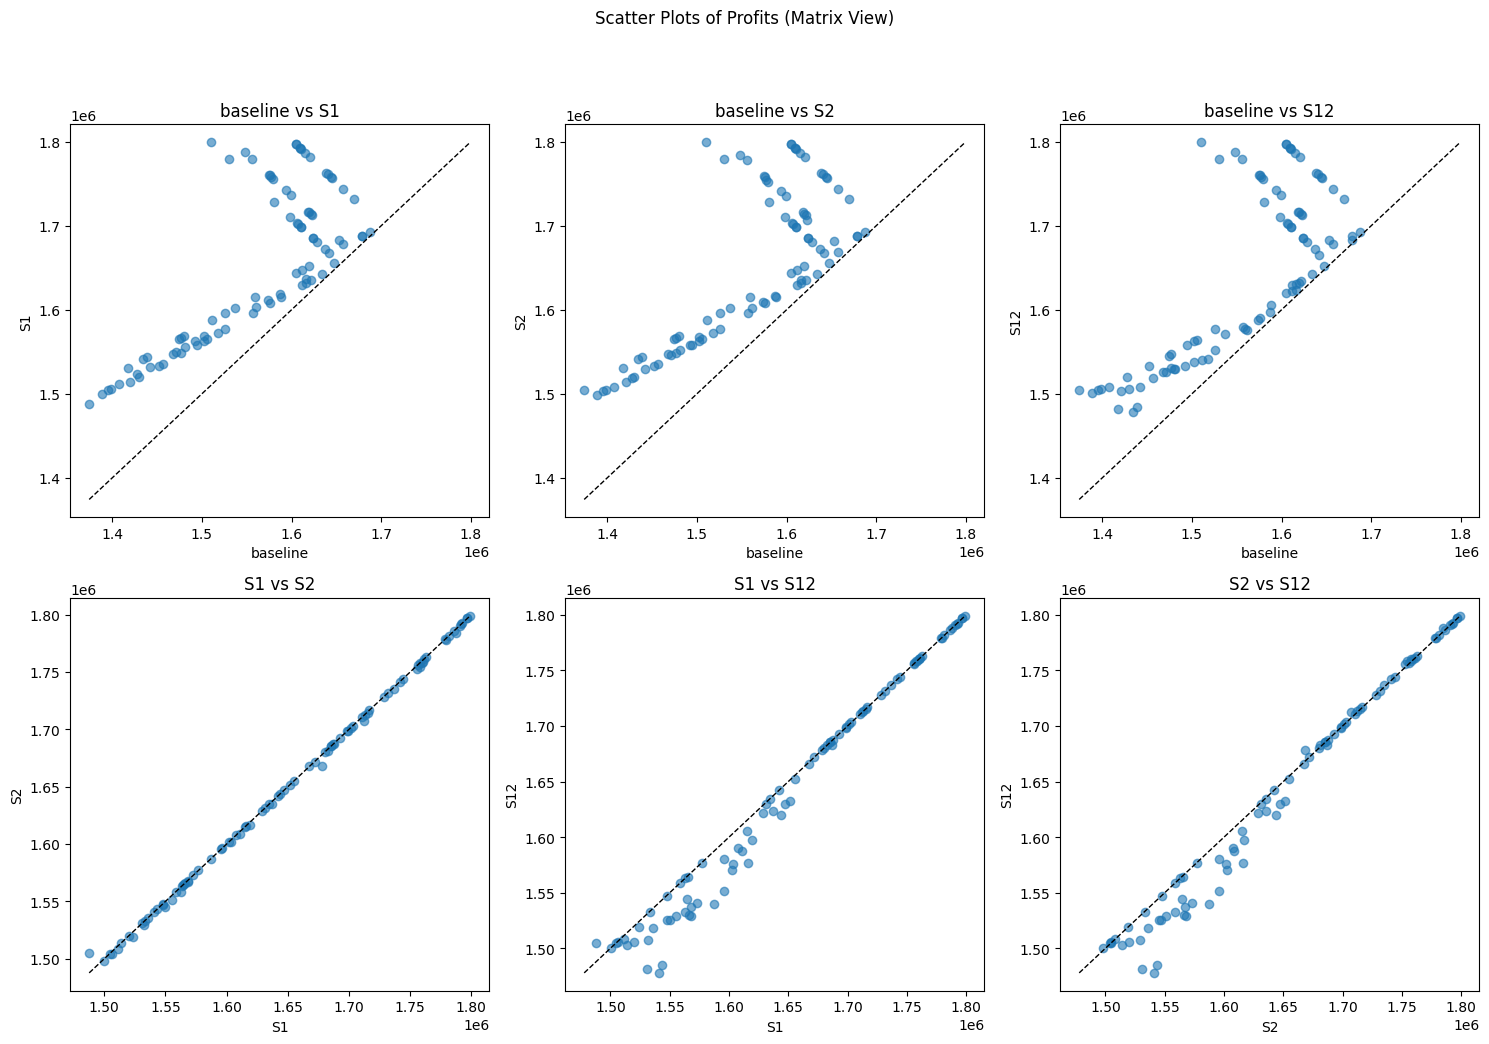

In [94]:
# 訓練階段分佈

baseline_data = []
S1_data = []
S2_data = []
S12_data = []
S14_data = []
S15_data = []

for result in train_all_fold_stimulation_results:
    baseline_data.append(result["baseline"])
    S1_data.append(result["S1"])
    S2_data.append(result["S2"])
    S12_data.append(result["S12"])
    # S14_data.append(result["S14"])
    # S15_data.append(result["S15"])

# 合併數據
baseline_df = pd.concat(baseline_data, ignore_index=True)
S1_df = pd.concat(S1_data, ignore_index=True)
S2_df = pd.concat(S2_data, ignore_index=True)
S12_df = pd.concat(S12_data, ignore_index=True)
# S14_df = pd.concat(S14_data, ignore_index=True)
# S15_df = pd.concat(S15_data, ignore_index=True)


dfs = {
    "baseline": baseline_df,
    "S1": S1_df,
    "S2": S2_df,
    "S12": S12_df,
    # "S15": S15_df,
    # "S14": S14_df,
}

# 調用繪圖函數
plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0.png


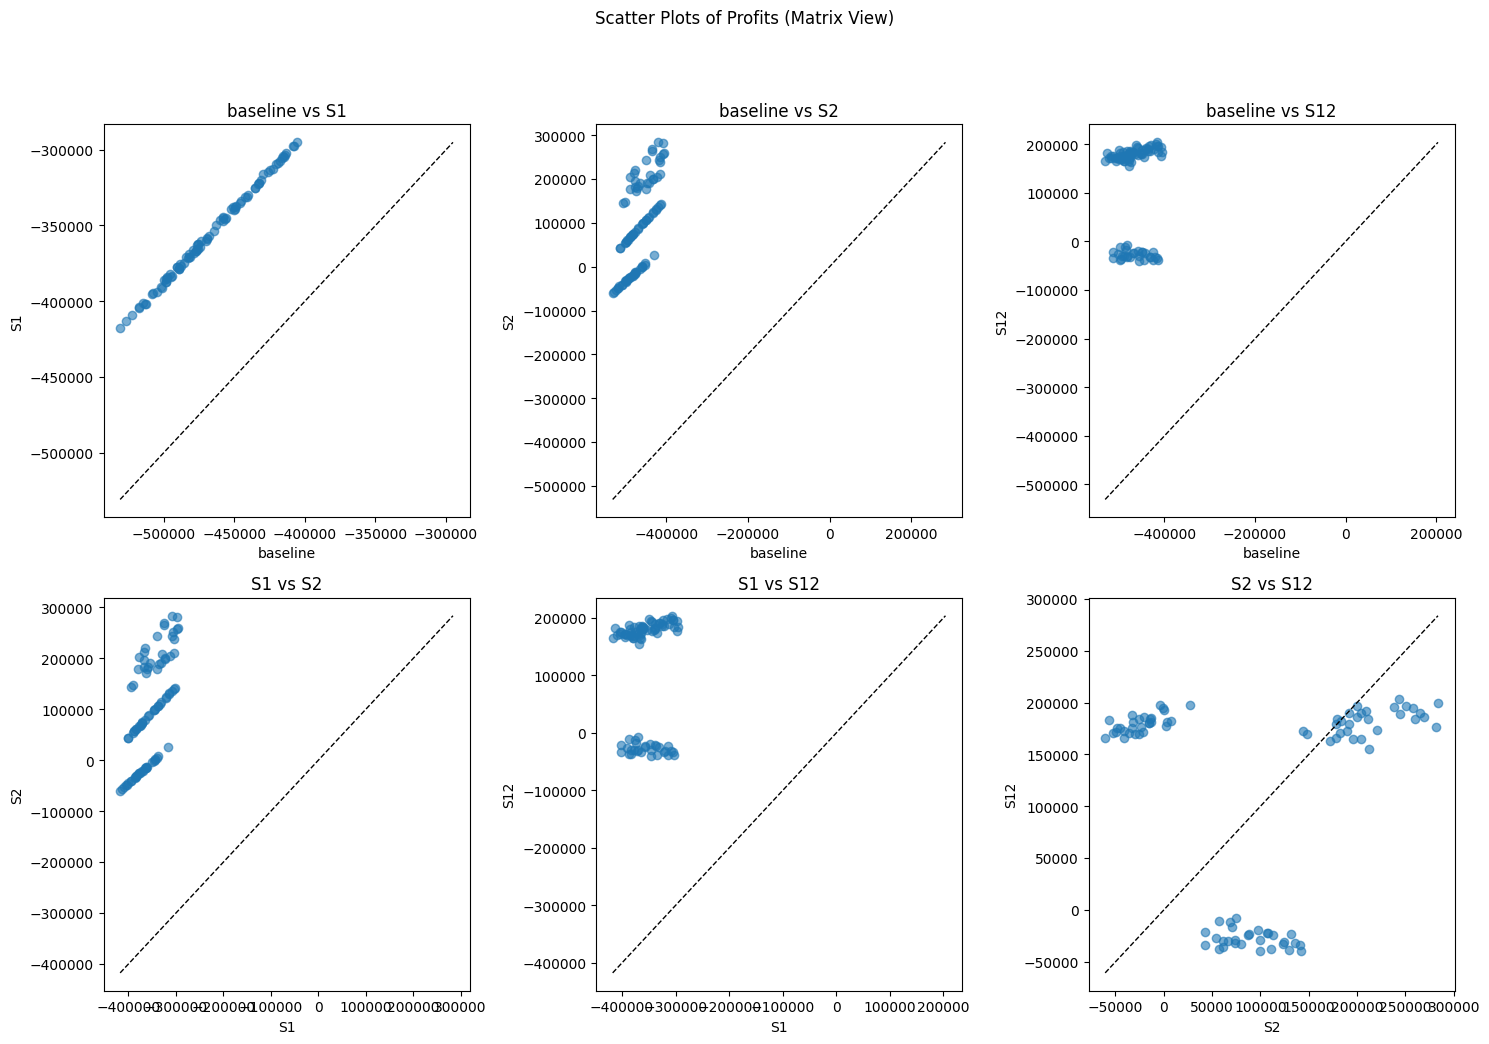

In [95]:
# 測試結果分布圖

baseline_data = []
S1_data = []
S2_data = []
S12_data = []
S14_data = []
S15_data = []

for result in test_all_fold_stimulation_results:
    baseline_data.append(result["baseline"])
    S1_data.append(result["S1"])
    S2_data.append(result["S2"])
    S12_data.append(result["S12"])

# 合併數據
baseline_df = pd.concat(baseline_data, ignore_index=True)
S1_df = pd.concat(S1_data, ignore_index=True)
S2_df = pd.concat(S2_data, ignore_index=True)
S12_df = pd.concat(S12_data, ignore_index=True)


dfs = {
    "baseline": baseline_df,
    "S1": S1_df,
    "S2": S2_df,
    "S12": S12_df,
}

# 調用繪圖函數
plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

#### EDA

In [96]:
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    print(f"training_df: \n{training_df}")
    print(f"demand_df_train: \n{demand_df_train}")
    print(f"testing_df: \n{testing_df}")
    print(f"demand_df_test: \n{demand_df_test}")

===== Processing Fold 1 =====
training_df: 
           X1   X2          X3
0   17.744068  0.0  263.227781
1   18.575947  0.0  288.711684
2   18.013817  0.0  272.807517
3   17.724416  0.0  278.421697
4   17.118274  0.0  250.939490
5   18.229471  0.0  280.881775
6   17.187936  0.0  280.604786
7   19.458865  0.0  280.846700
8   19.818314  0.0  297.187404
9   16.917208  0.0  284.091015
10  18.958625  0.0  267.975395
11  17.644475  0.0  271.851598
12  17.840223  0.0  284.881560
13  19.627983  0.0  253.011274
14  15.355180  0.0  283.338336
15  15.435646  0.0  283.531893
16  15.101092  0.0  260.519128
17  19.163099  0.0  256.446315
18  18.890784  0.0  265.771418
19  19.350061  0.0  268.185539
20  19.893092  0.0  278.509839
21  18.995793  0.0  271.930076
22  17.307397  0.0  299.418692
23  18.902646  0.0  255.102241
24  15.591372  0.0  260.443838
25  18.199605  0.0  258.065476
26  15.716766  0.0  282.655416
27  19.723345  0.0  262.664580
28  17.609242  0.0  273.315539
29  17.073310  0.0  262.22

In [97]:
demand_df_train.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,296.022378,298.874757,303.625479,298.874757,298.554637,298.874757,291.982439,299.764339,298.874757,298.874757
1,292.828135,293.825262,292.673713,293.825262,296.352055,293.825262,294.843930,292.262864,293.825262,293.825262
2,262.729699,266.907947,265.637434,266.907948,266.064213,266.907948,264.385756,266.307309,266.907948,266.907948
3,297.407410,298.078508,297.480821,298.078508,303.861762,298.078508,301.648396,296.928937,298.078508,298.078508
4,256.253615,261.585080,254.963369,261.585081,266.914723,261.585081,264.734748,262.925465,261.585081,261.585081


##### S1

In [98]:
Q_star

np.float64(2834.5933011406673)

In [99]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)

results_df_1

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
71,9,0.9,"[2551.1339710266006, 2551.1339710266006, 2551....","[433.1890859027121, 386.9530380468386, 108.530...",1.675420e+06,1.023356e-09,317.886558,1.675993e+06
61,8,0.8,"[2267.674640912534, 2267.674640912534, 2267.67...","[719.6335796431504, 672.3743898072798, 394.733...",1.674702e+06,6.651990e-01,313.566727,1.675594e+06
62,8,0.9,"[2551.1339710266006, 2551.1339710266006, 2551....","[436.1742495290837, 388.91505969321315, 111.27...",1.674159e+06,6.531704e-01,598.419061,1.675601e+06
41,6,0.6,"[1700.7559806844006, 1700.7559806844006, 1700....","[1289.7375678168287, 1238.8682268081134, 962.6...",1.674155e+06,9.506088e-01,305.160711,1.675423e+06
42,6,0.7,"[1984.2153107984673, 1984.2153107984673, 1984....","[1006.278237702762, 955.4088966940467, 679.199...",1.674155e+06,9.506088e-01,588.620041,1.675423e+06
...,...,...,...,...,...,...,...,...
55,8,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[2420.389560327551, 2373.1303704916804, 2095.4...",-5.457094e+05,1.388422e+03,1388.989618,8.429397e+05
45,7,0.1,"[283.45933011406674, 283.45933011406674, 283.4...","[2707.034218620162, 2656.16487724486, 2379.955...",-5.534427e+05,1.393199e+03,1393.991168,8.400733e+05
64,9,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[2417.4043967011794, 2371.168348845306, 2092.7...",-9.924252e+05,1.667761e+03,1667.761284,6.753361e+05
54,8,0.1,"[283.45933011406674, 283.45933011406674, 283.4...","[2703.8488904416176, 2656.589700605747, 2378.9...",-9.992443e+05,1.671881e+03,1672.448948,6.728641e+05


In [100]:
# Train
result = results_df_1.iloc[:, 0:2]
for i in range(len(result)):
    print(f"R: {result.iloc[i, 0]}, F: {result.iloc[i, 1]}")

R: 9, F: 0.9
R: 8, F: 0.8
R: 8, F: 0.9
R: 6, F: 0.6000000000000001
R: 6, F: 0.7000000000000001
R: 6, F: 0.8
R: 7, F: 0.7000000000000001
R: 7, F: 0.8
R: 6, F: 0.9
R: 7, F: 0.9
R: 4, F: 0.6000000000000001
R: 4, F: 0.4
R: 4, F: 0.5
R: 4, F: 0.7000000000000001
R: 4, F: 0.8
R: 5, F: 0.8
R: 5, F: 0.7000000000000001
R: 5, F: 0.6000000000000001
R: 5, F: 0.5
R: 3, F: 0.4
R: 3, F: 0.5
R: 3, F: 0.6000000000000001
R: 3, F: 0.7000000000000001
R: 3, F: 0.8
R: 3, F: 0.30000000000000004
R: 4, F: 0.9
R: 5, F: 0.9
R: 3, F: 0.9
R: 2, F: 0.6000000000000001
R: 2, F: 0.4
R: 2, F: 0.30000000000000004
R: 2, F: 0.7000000000000001
R: 2, F: 0.8
R: 2, F: 0.2
R: 2, F: 0.5
R: 2, F: 0.9
R: 2, F: 0.1
R: 3, F: 0.2
R: 4, F: 0.30000000000000004
R: 5, F: 0.4
R: 6, F: 0.5
R: 7, F: 0.6000000000000001
R: 8, F: 0.7000000000000001
R: 9, F: 0.8
R: 9, F: 0.7000000000000001
R: 8, F: 0.6000000000000001
R: 7, F: 0.5
R: 6, F: 0.4
R: 5, F: 0.30000000000000004
R: 4, F: 0.2
R: 3, F: 0.1
R: 9, F: 0.6000000000000001
R: 8, F: 0.5
R: 7, F

In [101]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_test,
    demand_df_train=demand_df_test,
    Q_star=Q_star,
)

results_df_1

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
64,9,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[49.42292041779854, 115.9831559436983, 40.3484...",387813.821364,6.972779e-07,49.681963,387813.822309
55,8,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[51.536777706734256, 114.93383514820573, 39.59...",386670.699324,5.814653e-01,115.036935,387464.943570
37,6,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[50.81557296038227, 114.88321294757282, 39.066...",385796.792877,1.015341e+00,245.879597,387204.618398
46,7,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[50.81557296711128, 114.88321294719151, 39.066...",385796.792877,1.015341e+00,181.319760,387204.618398
28,5,0.2,"[566.9186602281335, 566.9186602281335, 566.918...","[53.9204167774144, 116.4754550473316, 39.04424...",385032.124000,1.402929e+00,310.618127,386972.065530
...,...,...,...,...,...,...,...,...
71,9,0.9,"[2551.1339710266006, 2551.1339710266006, 2551....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-374097.217198,0.000000e+00,3938.674872,387813.822728
26,4,0.9,"[2551.1339710266006, 2551.1339710266006, 2551....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-374097.217198,0.000000e+00,4261.425413,387813.822728
8,2,0.9,"[2551.1339710266006, 2551.1339710266006, 2551....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-374097.217198,0.000000e+00,4390.554026,387813.822728
35,5,0.9,"[2551.1339710266006, 2551.1339710266006, 2551....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-374097.217198,0.000000e+00,4196.865576,387813.822728


In [102]:
# Test
result = results_df_1.iloc[:, 0:2]
for i in range(len(result)):
    print(f"R: {result.iloc[i, 0]}, F: {result.iloc[i, 1]}")

R: 9, F: 0.2
R: 8, F: 0.2
R: 6, F: 0.2
R: 7, F: 0.2
R: 5, F: 0.2
R: 5, F: 0.1
R: 4, F: 0.1
R: 4, F: 0.2
R: 3, F: 0.1
R: 3, F: 0.2
R: 2, F: 0.1
R: 2, F: 0.2
R: 6, F: 0.1
R: 9, F: 0.30000000000000004
R: 8, F: 0.30000000000000004
R: 4, F: 0.30000000000000004
R: 5, F: 0.30000000000000004
R: 7, F: 0.30000000000000004
R: 2, F: 0.30000000000000004
R: 6, F: 0.30000000000000004
R: 3, F: 0.30000000000000004
R: 7, F: 0.1
R: 9, F: 0.4
R: 7, F: 0.4
R: 5, F: 0.4
R: 8, F: 0.4
R: 6, F: 0.4
R: 4, F: 0.4
R: 3, F: 0.4
R: 2, F: 0.4
R: 8, F: 0.1
R: 4, F: 0.5
R: 7, F: 0.5
R: 9, F: 0.5
R: 6, F: 0.5
R: 8, F: 0.5
R: 2, F: 0.5
R: 3, F: 0.5
R: 5, F: 0.5
R: 9, F: 0.1
R: 4, F: 0.6000000000000001
R: 8, F: 0.6000000000000001
R: 6, F: 0.6000000000000001
R: 5, F: 0.6000000000000001
R: 9, F: 0.6000000000000001
R: 7, F: 0.6000000000000001
R: 2, F: 0.6000000000000001
R: 3, F: 0.6000000000000001
R: 4, F: 0.7000000000000001
R: 9, F: 0.7000000000000001
R: 2, F: 0.7000000000000001
R: 7, F: 0.7000000000000001
R: 8, F: 0.70000

##### S2

In [103]:
training_df.head()

,X1,X2,X3
0,19.319278,0.0,298.874757
1,15.587659,0.0,293.825262
2,17.586896,0.0,266.907948
3,15.660341,0.0,298.078508
4,18.584298,0.0,261.585081


In [104]:
demand_df_train.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,296.022378,298.874757,303.625479,298.874757,298.554637,298.874757,291.982439,299.764339,298.874757,298.874757
1,292.828135,293.825262,292.673713,293.825262,296.352055,293.825262,294.843930,292.262864,293.825262,293.825262
2,262.729699,266.907947,265.637434,266.907948,266.064213,266.907948,264.385756,266.307309,266.907948,266.907948
3,297.407410,298.078508,297.480821,298.078508,303.861762,298.078508,301.648396,296.928937,298.078508,298.078508
4,256.253615,261.585080,254.963369,261.585081,266.914723,261.585081,264.734748,262.925465,261.585081,261.585081


In [105]:
demand_df_test.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,60.055069,61.843260,62.469487,61.811510,60.735119,61.811510,62.123483,61.869124,61.811510,61.811510
1,73.123778,68.322375,68.363755,67.885455,63.412671,67.885455,70.948591,67.188827,67.885455,67.885455
2,58.590534,57.659424,58.626662,60.568481,66.984752,60.568481,61.479343,61.652497,60.568470,60.568481
3,73.090434,68.033764,71.133459,66.969972,64.180797,66.969972,67.213965,64.440903,66.969968,66.969972
4,62.986085,67.187879,64.822610,67.786954,65.991975,67.786954,69.536594,69.239974,67.786955,67.786954


In [106]:
Qk_hat_df_train.head()

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9,Qk_hat_k10
0,2967.483830,2989.779014,2991.078980,2991.078981,2990.493549,2990.493549,2987.308221,2984.323057,2984.323057
1,2936.545624,2939.771245,2939.252545,2939.252544,2939.624207,2939.624207,2940.049031,2938.087009,2938.087009
2,2645.023693,2669.558324,2669.699035,2669.699036,2663.414414,2663.414414,2662.408401,2659.664149,2659.664149
3,2980.898727,2982.418853,2981.967095,2981.967094,2988.643301,2988.643300,2990.829344,2987.719866,2987.719866
4,2582.298823,2615.978203,2614.820983,2614.820985,2615.018352,2615.018353,2614.996464,2613.717325,2613.717325


In [107]:
Qk_hat_df_test.head()

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9,Qk_hat_k10
0,624.278940,624.693374,623.750712,620.839077,617.734233,617.734233,618.455438,616.341581,616.341321
1,687.750931,684.904284,686.273308,683.394115,681.801873,681.801873,681.852495,682.901816,682.901927
2,617.166000,595.774040,595.100145,605.962908,605.985008,605.985008,606.518082,607.267128,607.267202
3,687.588985,683.006028,681.523235,676.055541,677.623906,677.623906,678.196126,675.973208,675.973948
4,638.514275,663.150391,664.558354,668.778303,668.756732,668.756732,669.616258,670.912938,670.913316


In [108]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)

results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 338 rows, 518 columns and 886 nonzeros
Model fingerprint: 0x7174a00d
Model has 240 general constraints
Variable types: 518 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [2e+02, 3e+03]
Presolve removed 112 row

,R(T),R,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,F_vars,f_vars,Q0_vars,Q1_vars
7,9,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",1.675993e+06,0.000000,119.682508,1.675993e+06,"[0.0, 0.0, 0.005701364851208362, 0.0]","[0.8460556591543597, 0.842268552614203, 0.8207...","[1.703994034400385, 1.6752050226794741, 1.5217...","[2398.2237038310996, 2387.4887970016653, 2326....","[586.0993530982132, 550.5982120717738, 333.045..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1.673034e+06,1.498696,582.694735,1.675094e+06,"[0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1417.2966505703337, 1417.2966505703337, 1417....","[1573.7823295517671, 1521.955894494529, 1252.4..."
3,5,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",1.673034e+06,1.498696,303.373971,1.675094e+06,"[0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1417.2966505703337, 1417.2966505703337, 1417....","[1573.7823303374282, 1521.955893909945, 1252.4..."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.672965e+06,1.539378,862.276971,1.675069e+06,"[0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1417.2966505703337, 1417.2966505703337, 1417....","[1572.482363228388, 1522.474594748195, 1252.26..."
6,8,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...",1.669993e+06,3.607865,5.989093,1.673828e+06,"[4.7266416575186257e-05, 0.0, 0.01126341229455...","[0.7355985964790888, 0.7243544907537749, 0.659...","[1.0232161684460175, 0.9661652472734782, 0.663...","[2085.1228539081017, 2053.25038714181, 1870.69...","[902.1853666475824, 886.798643578004, 791.7137..."
4,6,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",1.667663e+06,5.007926,15.266336,1.672988e+06,"[-0.0014825092377474956, 0.0, 0.00572097882584...","[0.5219186470290125, 0.516088174803087, 0.4768...","[0.0877308146235698, 0.06437492150959256, -0.0...","[1479.4271006088393, 1462.900083094744, 1351.7...","[1511.06644789239, 1476.7241243977699, 1311.67..."
0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.665817e+06,4.883126,1149.436431,1.673063e+06,"[0.0, 0.0, 0.0, 0.0]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1417.2966505703337, 1417.2966505703337, 1417....","[1550.187179298806, 1519.248973496182, 1227.72..."
5,7,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",1.662196e+06,8.425269,9.217197,1.670938e+06,"[0.000729853811890759, 0.0, 0.0086954565945427...","[0.6297080345781972, 0.6187704245493308, 0.562...","[0.5309623208835497, 0.48433112254023714, 0.25...","[1784.9661764898135, 1753.9625003715, 1594.749...","[1205.5273722444151, 1185.6617069874264, 1068...."


In [109]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_test,
    Qk_hat_df_train=Qk_hat_df_test,
    training_df=testing_df,
)

results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 338 rows, 518 columns and 916 nonzeros
Model fingerprint: 0x0b4de247
Model has 240 general constraints
Variable types: 518 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 7e+02]
  GenCon const rng [6e+01, 6e+02]
Presolve removed 88 rows

,R(T),R,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,F_vars,f_vars,Q0_vars,Q1_vars
7,9,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",384377.626083,0.000000,146.300655,387813.822728,"[-0.002140167244561731, -1.206002144950703, 0....","[0.22070000494673228, 0.24176623249668228, 0.2...","[-1.2615916618971954, -1.143019904181749, -1.2...","[625.5947555837195, 685.3089430771126, 616.940...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",384075.979576,0.000000,405.999592,387813.822728,"[0.00013040511206433307, -1.215685098367246, 0...","[0.2220957694219178, 0.24267180103119587, 0.21...","[-1.253494729707588, -1.1380867808368924, -1.2...","[629.5511802150505, 687.8758615787686, 617.871...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,7,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",383991.239719,0.000000,277.873833,387813.822728,"[-0.00227925494968541, -1.1912347401461458, 0....","[0.22115841421743815, 0.24183626974941072, 0.2...","[-1.2589283407041623, -1.1426380025004998, -1....","[626.8941594316431, 685.5074702045271, 618.655...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",383991.239714,0.000000,342.433670,387813.822728,"[-0.002279254952404404, -1.1912347399372416, 0...","[0.221158414223092, 0.2418362697500157, 0.2182...","[-1.2589283406713383, -1.1426380024972005, -1....","[626.8941594476694, 685.5074702062419, 618.655...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,8,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...",383902.044843,0.000000,212.920123,387813.822728,"[-0.0034155600542733018, -1.1931039680358433, ...","[0.22055606263471425, 0.24173675993166205, 0.2...","[-1.2624288493454112, -1.1431812406611461, -1....","[625.1867376703225, 685.2254003417389, 618.319...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",383213.899202,0.000000,474.869831,387813.822728,"[-0.0024557891124595012, -1.1675173432632244, ...","[0.22205015676232928, 0.24210650881601045, 0.2...","[-1.2537586408699493, -1.141165457514952, -1.2...","[629.4218868757337, 686.2734880524172, 621.783...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",382876.306807,0.000000,541.358922,387813.822728,"[-0.0033789282306211205, -1.1425153942517237, ...","[0.22217500717327973, -1, 0.22004070856521962,...","[-1.2530360233265379, -1, -1.2654291167817446,...","[629.7757870142584, -1, 623.7259184772174, 683...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",382143.965596,1.605759,563.277398,386850.367502,"[-0.019513355862523746, -3.3677307963074052, 0...","[-1, -1, 0.1944580710158482, 0.239282718709714...","[-1, -1, -1.4212987262390675, -1.1566180522057...","[-1, -1, 551.2095454542595, 678.2691915332833,...","[77.19970490098125, 26.500065516988347, 65.956..."


In [110]:
num_neg_ones = results_df_2.iloc[0]["F_vars"].count(-1)
print("F_vars 中有 -1 的個數：", num_neg_ones)

F_vars 中有 -1 的個數： 0


In [111]:
demand_df_test_analysis = demand_df_test.copy()
demand_df_test_analysis["sum_first_8"] = demand_df_test_analysis.iloc[:, :8].sum(axis=1)
demand_df_test_analysis["sum"] = demand_df_test_analysis.iloc[:, :10].sum(axis=1)

demand_df_test_analysis["Lost_0"] = (
    demand_df_test_analysis["sum_first_8"] - results_df_2.iloc[0]["Q0_vars"]
)
demand_df_test_analysis.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10,sum_first_8,sum,Lost_0
0,60.055069,61.843260,62.469487,61.811510,60.735119,61.811510,62.123483,61.869124,61.811510,61.811510,492.718561,616.341581,-132.876195
1,73.123778,68.322375,68.363755,67.885455,63.412671,67.885455,70.948591,67.188827,67.885455,67.885455,547.130908,682.901818,-138.178035
2,58.590534,57.659424,58.626662,60.568481,66.984752,60.568481,61.479343,61.652497,60.568470,60.568481,486.130173,607.267124,-130.810721
3,73.090434,68.033764,71.133459,66.969972,64.180797,66.969972,67.213965,64.440903,66.969968,66.969972,542.033266,675.973206,-137.967635
4,62.986085,67.187879,64.822610,67.786954,65.991975,67.786954,69.536594,69.239974,67.786955,67.786954,535.339026,670.912935,-151.023117


In [112]:
demand_df_test_analysis[demand_df_test_analysis["Lost_0"] >= 0]

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10,sum_first_8,sum,Lost_0


In [113]:
# demand_df_test_analysis.head()
results_df_2.iloc[0]

R(T)                                                                         9
R                            [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...
average_profits                                                  384377.626083
average_losses                                                             0.0
average_lefts                                                       146.300655
average_operation_profits                                        387813.822728
alpha_values                 [-0.002140167244561731, -1.206002144950703, 0....
F_vars                       [0.22070000494673228, 0.24176623249668228, 0.2...
f_vars                       [-1.2615916618971954, -1.143019904181749, -1.2...
Q0_vars                      [625.5947555837195, 685.3089430771126, 616.940...
Q1_vars                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 7, dtype: object